# X-Y allele frequency dynamics under meiotic drive

In [33]:
import pandas as pd
import numpy as np
from numpy.random import choice
from random import random, randint, sample, seed
from collections import defaultdict
import scipy.stats
import h5py

In [34]:
# import multiprocessing
import multiprocess
import sys
import collections
from random import random
from time import sleep
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

#import matplotlib.animation as animation

from matplotlib import animation, rc
from IPython.display import HTML

from matplotlib.lines import Line2D

import seaborn as sns
sns.set()
sns.set_style('ticks')
# sns.set_style('dark')

#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
colors = sns.color_palette("Set1", 9)
#colors = sns.color_palette("rainbow", 8)

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)


#sns.palplot(colors)

In [35]:
%matplotlib inline

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

# Make inline plots vector graphics instead of raster graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
# set_matplotlib_formats('svg', 'pdf')


We can sample drives between 0 and 1 from a beta:

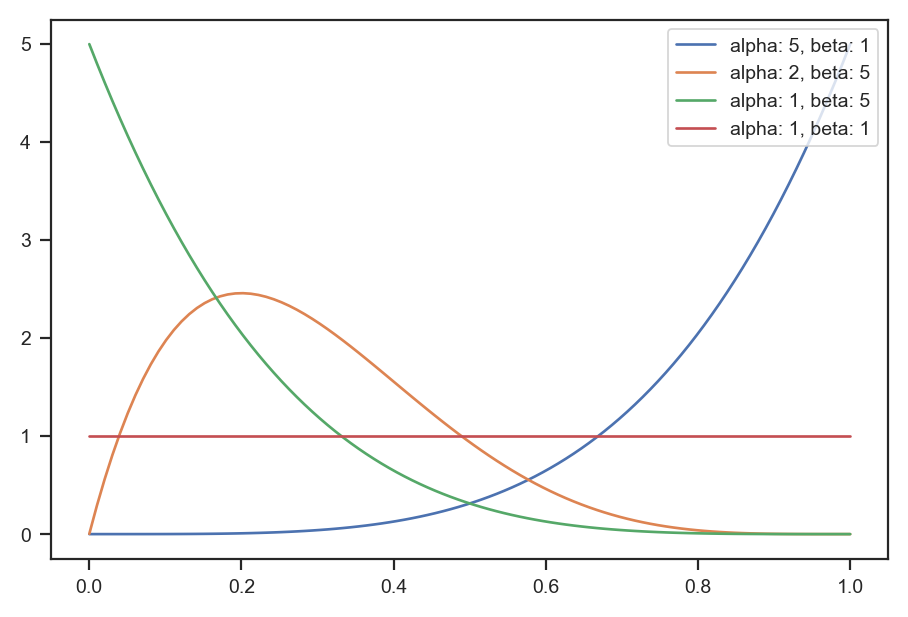

In [36]:
x = np.linspace(0.0001, 0.9999, 100)
for a, b in [(5, 1), (2, 5), (1, 5), (1, 1)]:
    plt.plot(x, scipy.stats.beta.pdf(x, a, b), label='alpha: {}, beta: {}'.format(a, b))
plt.legend(loc='upper right') ;

... but it does not matter which distribution such allele specivic values are drawn from. When we compute drive as `x_drive / (x_drive + y_drive)` this is always uniform:

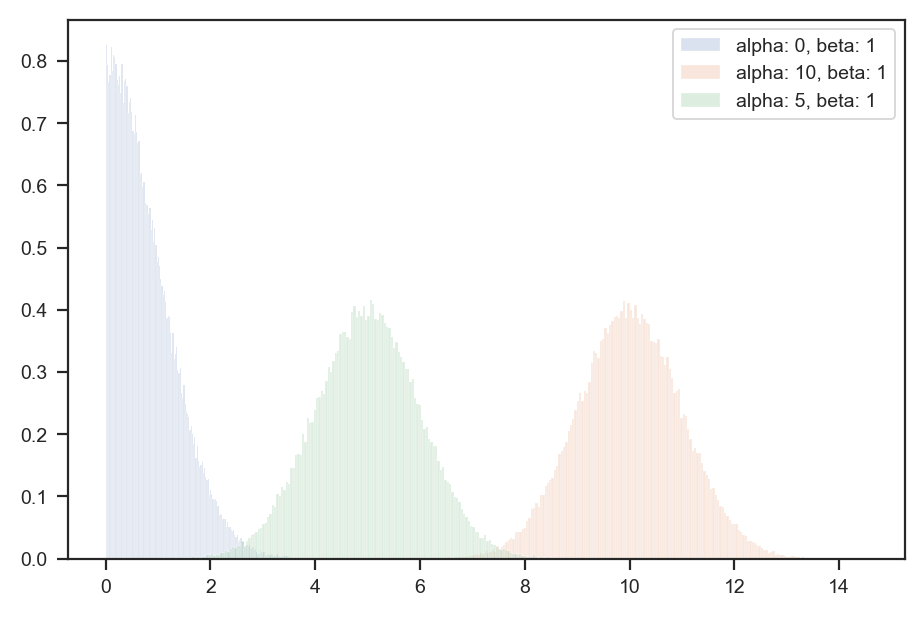

In [37]:
x = np.linspace(0.0001, 0.9999, 100000)
for a, b in [(0, 1), (10, 1), (5, 1)]:
    x_drive = abs(np.random.normal(a, b, size=len(x)))
    plt.hist(x_drive, density=True, bins=200, alpha=0.2, label='alpha: {}, beta: {}'.format(a, b))
plt.legend() ;

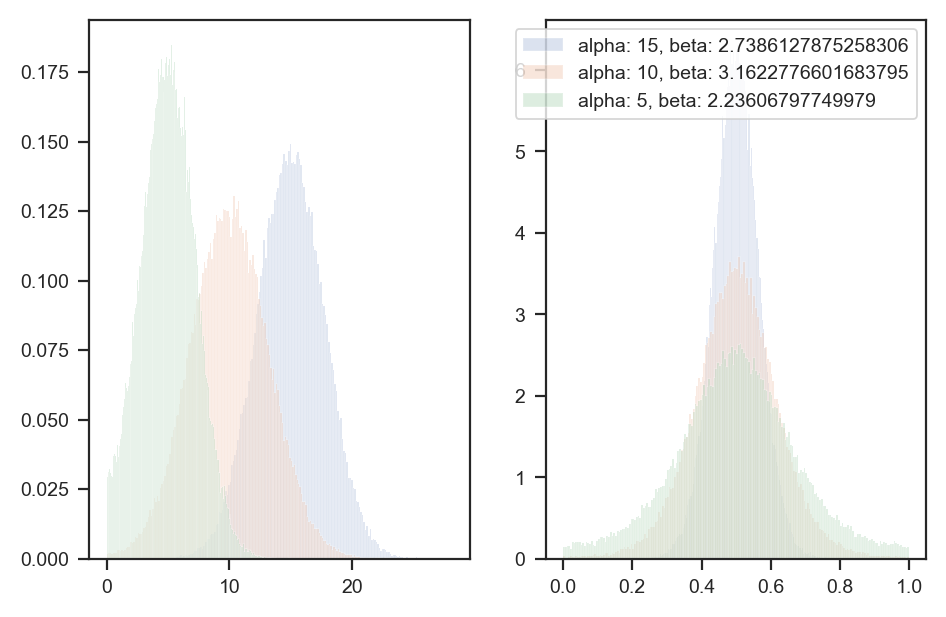

In [38]:
import math
fig, (ax1, ax2) = plt.subplots(1, 2)
x = np.linspace(0.0001, 0.9999, 100000)
for a, b in [(15, math.sqrt(15/2)), (10, math.sqrt(10)), (5, math.sqrt(5))]:
    x_drive = abs(np.random.normal(a, b, size=len(x)))
    y_drive = abs(np.random.normal(a, b, size=len(x)))
    ax1.hist(x_drive, density=True, bins=200, alpha=0.2)
    ax2.hist(x_drive / (x_drive + y_drive), density=True, bins=200, alpha=0.2, label='alpha: {}, beta: {}'.format(a, b))
plt.legend() ;

- This notebook simulates 10 (or any other) number of loci spread across the X chromosome. 
- Each locus interacts with a competing locus on the Y chromosome.
- All loci start out with a "drive" values that determines its functional relationship to each allele at the competing locus. The initial drive value is sampled from a normal distribution with a mean of 100 and a standard deviation of 1.
- The X chromosome recombines once in each female meiosis.
- In each male meiosis, the meiotic drive (female bias) is computed as `x_allele_drive_value / (x_allele_drive_value + y_allele_drive_value)`. I.e. the relative ability fo the two alleles to drive against each other.
- All X and Y alleles allele mutates at the same rate. This independently perturbs each all associated drive values by a value sampled form a normal distribution with a mean of 0 and a standard deviation of 20.
- The motivation for indpendence of drive value pertubations is that with a large number of interacting genes outside the model each drive value (e.g. expression level) may have unique properties. I.e. the alterantive would be to only update the mutating allele and assume that this change completely captures its relation to the alleles on the competing locus.

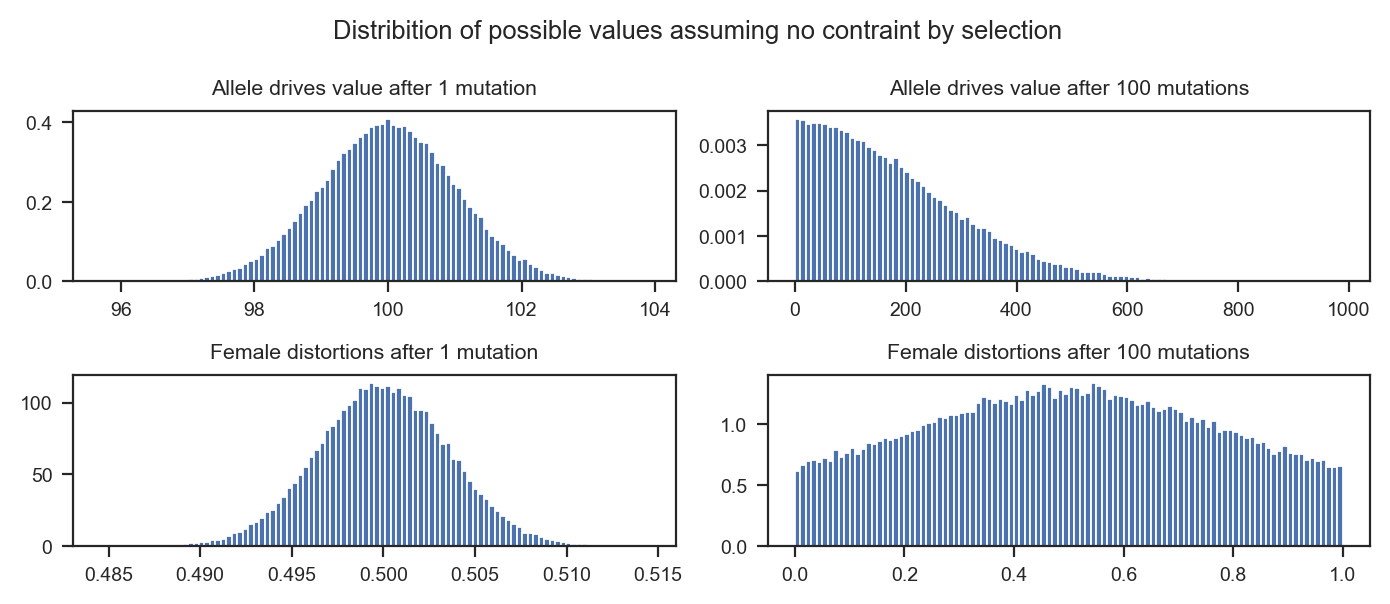

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(7, 3))
x = np.linspace(0.0001, 0.9999, 100000)
init_x_drives = np.random.normal(100, 1, size=len(x))
init_y_drives = np.random.normal(100, 1, size=len(x))
#ax1.hist(init_x_drives, density=True, bins=200, alpha=0.2)
axes[0, 0].hist(init_x_drives, density=True, bins=100)
axes[0, 0].set_title('Allele drives value after 1 mutation')
axes[1, 0].hist(init_x_drives / (init_x_drives + init_y_drives), density=True, bins=100)
axes[1, 0].set_title('Female distortions after 1 mutation')
for i in range(99):
    x_drive = np.random.normal(0, 20, size=len(x))
    y_drive = np.random.normal(0, 20, size=len(x))
    init_x_drives += x_drive
    init_y_drives += y_drive
    init_x_drives = abs(init_x_drives)
    init_y_drives = abs(init_y_drives)
axes[0, 1].hist(init_x_drives, density=True, bins=100)
axes[0, 1].set_title('Allele drives value after 100 mutations')
axes[1, 1].hist(init_x_drives / (init_x_drives + init_y_drives), density=True, bins=100)
axes[1, 1].set_title('Female distortions after 100 mutations')
plt.suptitle('Distribition of possible values assuming no contraint by selection')
plt.tight_layout()

In [40]:
class Node:
    
    def __init__(self, nodeid, label, generation, parent):
        self.nodeid = nodeid
        self.label = label
        self.generation = generation
        self.parent = parent
        self.anc_child = None
        self.der_child = None
        
    def __repr__(self):
        p = self.parent.nodeid if self.parent is not None else None
        a = self.anc_child.nodeid if self.anc_child is not None else None
        d = self.der_child.nodeid if self.der_child is not None else None
        return f"ID: {self.nodeid}, Parent: {p}, Anc child: {a}, Der child: {d}, label: {self.label}, generation: {self.generation}"


#terminal_nodes = deque()
terminal_nodes = dict()
all_nodes = dict()

# tmrca node joining both populations
tmrca_node = Node(nodeid=0, label=None, generation=0, parent=None)
all_nodes[tmrca_node.label] = tmrca_node

# initialize
node = Node(nodeid=len(all_nodes), label=0, generation=0, parent=tmrca_node)
all_nodes[node.label] = node
terminal_nodes[node.label] = node


def update_tree(parent_label, child_label, generation, terminal_nodes, all_nodes):
    
    # mutate allele 1:
    mutating_node = terminal_nodes[parent_label]

    # append new nodes
    anc_child_node = Node(nodeid=len(all_nodes), label=mutating_node.label, generation=generation, parent=mutating_node)
    all_nodes[anc_child_node.label] = anc_child_node
    terminal_nodes[anc_child_node.label] = anc_child_node
    mutating_node.anc_child = anc_child_node
    der_child_node =  Node(nodeid=len(all_nodes), label=child_label, generation=generation, parent=mutating_node)
    all_nodes[der_child_node.label] = der_child_node
    terminal_nodes[der_child_node.label] = der_child_node
    mutating_node.der_child = der_child_node
    
update_tree(0, 777, 10, terminal_nodes, all_nodes)
update_tree(777, 888, 5, terminal_nodes, all_nodes)
update_tree(0, 999, 15, terminal_nodes, all_nodes)


# for i in range(len(all_nodes)):
#     print(all_nodes[i])
# print()
# for label in terminal_nodes:
#     print(terminal_nodes[label])
# print()

node1 = terminal_nodes[888]
node2 = terminal_nodes[999]

def parents(node):
    if node.parent is None:
        return []
    return [node.label] + parents(node.parent)

def available_coal_span(node1, node2):

    a = parents(node1)
    b = parents(node2)
    for i in range(min(len(a), len(b))):
        if a[i] != b[i]:
            max_coal_gen = all_nodes[a[i-1]].generation
        min_coal_gen = min(all_nodes[a[i]].generation, all_nodes[b[i]].generation)
    return max_coal_gen, min_coal_gen

def expected_coal_time(node1, node2, demography, freq_trajectory):
    
    if node1.label == node2.label:
        max_gen, min_gen = node1.generation, len(demography)
    else:
        max_gen, min_gen = available_coal_span(node1, node2)
    exptime = 0
    prev_exptime = 1
    for gen in range(max_gen, min_gen - max_gen):
        exptime, prev_exptime = exptime + 1 + ((1-1/(demography[gen]*freq_trajectory[gen])) * prev_exptime), exptime
    return max_gen + exptime
    
# pop1_size = 100
# pop1_demog = [[pop1_size, 10000]]
# pop1_size_history = [x for (size, gens) in pop1_demog for x in [size]*gens]

# freqs = dict(zip(x_freqs['pop1'][0][0], y_freqs['pop1'][0][0]))

# pwdists = defaultdict(dict)
# for a, b in zip(all_nodes.keys(), all_nodes.keys()):
#     n1 = all_nodes[a]
#     n2 = all_nodes[b]
#     pwdists[a][b] = expected_coal_time(n1, n2, pop1_size_history, freqs)

# # lookup table for computing mean pwdist of all indivs:
# print(pwdists)    

## TODO:

- The cumulative changes becomes relatively smaller the further from 0 a drive is (as long time pases, changes will become very small)
- Add autosomes
- Track selection coeficients


In [42]:
## seed(7)

class Allele:
    __slots__ = ('chrom', 'label', 'val')
    
    def __init__(self, chrom, label, val):
        self.chrom = chrom
        self.label = label
        self.val = val
    
class Male:
    __slots__ = ('x_alleles', 'y_alleles', 'parent_female_offspring_ratio')
        
    def __init__(self, x_alleles, y_alleles, parent_female_offspring_ratio):
        # assert x_allele.chrom == 'X'
        # assert y_allele.chrom == 'Y'
        self.x_alleles = x_alleles
        self.y_alleles = y_alleles
        self.parent_female_offspring_ratio = parent_female_offspring_ratio        

    def __add__(self, female):
      
        # male gametes
        x_proportion = 0
        for locus in range(LOCI):
            x_drive = DRIVES[locus][self.x_alleles[locus].label][self.y_alleles[locus].label]
            y_drive = DRIVES[locus][self.y_alleles[locus].label][self.x_alleles[locus].label]
            x_proportion += x_drive / (x_drive + y_drive)
        x_proportion /= LOCI
        
        if random() < x_proportion:
            sperm_alleles = self.x_alleles[:]
        else:
            sperm_alleles = self.y_alleles[:]
        
        # female gametes
        lst = []
        recombination_point = random() * len(female.x1_alleles)
        for i, (a, b) in enumerate(zip(female.x1_alleles, female.x2_alleles)):
            if i < recombination_point:
                lst.append([a, b])
            else:
                lst.append([b, a])
            # if random() < 0.5:
            #     lst.append([a, b])
            # else:
            #     lst.append([b, a])
        x1_alleles, x2_alleles = map(list, zip(*lst))
            
        if random() < 0.5:
            egg_alleles = x1_alleles
        else:        
            egg_alleles = x2_alleles
  
        # make new individual
        if sperm_alleles[0].chrom == 'Y':
            return Male(egg_alleles, sperm_alleles, x_proportion)
        else:
            return Female(egg_alleles, sperm_alleles, x_proportion)
            
class Female:
    __slots__ = ('x1_alleles', 'x2_alleles', 'parent_female_offspring_ratio')

    def __init__(self, x1_alleles, x2_alleles, parent_female_offspring_ratio):
        # assert x1_allele.chrom == 'X'
        # assert x2_allele.chrom == 'X'
        self.x1_alleles = x1_alleles
        self.x2_alleles = x2_alleles
        self.parent_female_offspring_ratio = parent_female_offspring_ratio

    def __add__(self, male):
        return male + self
    

class Population:
    __slots__ = ('males', 'females', 'alpha', 'beta', 'pop_size', 'drive_coef', 'allele_val_map', 'mutation_tree', 'generation')
        
    def __init__(self, males=[], females=[], alpha=5, beta=1, generation=1):
        self.generation = generation
        self.males = males
        self.females = females
        self.alpha = alpha
        self.beta = beta
        self.pop_size = len(self.males) + len(self.females)
        self.drive_coef = defaultdict(dict)
        self.allele_val_map = defaultdict(dict)
        self.mutation_tree = dict()
        
    def initialize(self, pop_size, val=None):
        assert not pop_size % 2, 'initial pop_size must be even'
        self.males = [Male([Allele('X', CUR_XLABEL[locus], val) for locus in range(LOCI)], 
                           [Allele('Y', CUR_YLABEL[locus], val) for locus in range(LOCI)], np.nan) for _ in range(pop_size//2)]
        self.females = [Female([Allele('X', CUR_XLABEL[locus], val) for locus in range(LOCI)], 
                               [Allele('X', CUR_XLABEL[locus], val) for locus in range(LOCI)], np.nan) for _ in range(pop_size//2)]

        for locus in range(LOCI):
            self.update_drives(locus, None, CUR_XLABEL[locus])
            self.update_drives(locus, None, CUR_YLABEL[locus])
            self.allele_val_map[locus][CUR_XLABEL[locus]] = val
            self.allele_val_map[locus][CUR_YLABEL[locus]] = val
            self.update_tree(locus, -2, CUR_XLABEL[locus], self.generation) # root of x accross pops
            self.update_tree(locus, -1, CUR_YLABEL[locus], self.generation) # root of x accross pops

#     def update_drives(self, label):
#         # assert label >= len(self.DRIVES)

#         nrow = len(self.DRIVES[0]) if self.DRIVES else 1
#         row = np.random.normal(self.alpha, self.beta, size=nrow).tolist()
#         self.DRIVES.append(row)
        
#         ncol = len(self.DRIVES)
#         col = np.random.normal(self.alpha, self.beta, size=ncol).tolist()
#         for row, val in zip(self.DRIVES, col):
#             row.append(val)
            
    def update_drives(self, locus, parent_label, label):  
        global DRIVES
        
        assert label not in DRIVES[locus].columns.values, (label, DRIVES[locus].columns.values)

        cumulative = False
        
        nrows, ncols = DRIVES[locus].shape   
        if cumulative:
            if parent_label is None:
                parent2other_drives = np.random.normal(self.alpha, self.beta, size=nrows)
            else:
                parent2other_drives = DRIVES[locus][parent_label]
            DRIVES[locus][label] = np.abs(parent2other_drives + np.random.normal(0, 20, size=nrows))
        else:
            DRIVES[locus][label] = np.random.normal(self.alpha, self.beta, size=nrows)

        nrows, ncols = DRIVES[locus].shape 
        if cumulative:        
            if parent_label is None:
                other2parent_drives = np.random.normal(self.alpha, self.beta, size=ncols)
            else:
                other2parent_drives = DRIVES[locus].loc[parent_label]
            new_row = pd.DataFrame.from_records([np.abs(other2parent_drives + np.random.normal(0, 20, size=ncols))], 
                                                columns=DRIVES[locus].columns)                
        else:
            new_row = pd.DataFrame.from_records([np.random.normal(self.alpha, self.beta, size=ncols)], 
                                                columns=DRIVES[locus].columns)
        new_row.index = [label]
        DRIVES[locus] = pd.concat([DRIVES[locus], new_row])
        DRIVES[locus] = DRIVES[locus].copy() 
        
    def update_tree(self, locus, parent_label, child_label, generation):
    
        global NODES

        # mutate allele 1:
        mutating_node = NODES[locus][parent_label]

        # Only need NODES, but only add the der child node not the anc node
        
        # append new nodes
        # anc_child_node = Node(nodeid=len(NODES[locus]), label=mutating_node.label, generation=generation, parent=mutating_node)
        # NODES[locus][anc_child_node.label] = anc_child_node
        # mutating_node.anc_child = anc_child_node
        der_child_node =  Node(nodeid=len(NODES[locus]), label=child_label, generation=generation, parent=mutating_node)
        NODES[locus][der_child_node.label] = der_child_node
        mutating_node.der_child = der_child_node
                
    def resample(self, new_pop_size=None):
        if new_pop_size is None:
            new_pop_size = self.pop_size
        new_males = list()
        new_females = list()
        
        for i in range(new_pop_size):
            male = self.males[int(random() * len(self.males))]
            female = self.females[int(random() * len(self.females))]
            child = male + female
                        
            if isinstance(child, Male):
                new_males.append(child)
            else:
                new_females.append(child)       
                
        return Population(new_males, new_females, generation=self.generation+1)

    def mutate(self, x_mut_prob, y_mut_prob):

        global CUR_XLABEL
        global CUR_YLABEL

        for i in range(len(self.males)):
            for locus in range(LOCI):
                if random() < x_mut_prob:
                    CUR_XLABEL[locus] += 2
                    val = self.males[i].x_alleles[locus].val

                    parent_label = self.males[i].x_alleles[locus].label
                    child_label = CUR_XLABEL[locus]
                    self.males[i].x_alleles[locus] = Allele('X', child_label, val)
                    self.update_drives(locus, parent_label, child_label)
                    self.allele_val_map[locus][child_label] = val
                    self.update_tree(locus, parent_label, child_label, self.generation)
                    
                    # self.males[i].x_alleles[locus] = Allele('X', CUR_XLABEL[locus], val)
                    # self.update_drives(locus, CUR_XLABEL[locus])
                    # self.allele_val_map[locus][CUR_XLABEL[locus]] = val
                    # self.update_tree(locus, CUR_XLABEL[locus]-2, CUR_XLABEL[locus], self.generation)

                if random() < y_mut_prob:
                    CUR_YLABEL[locus] += 2
                    val = self.males[i].y_alleles[locus].val
                    
                    parent_label = self.males[i].y_alleles[locus].label
                    child_label = CUR_YLABEL[locus]
                    self.males[i].y_alleles[locus] = Allele('Y', child_label, val)
                    self.update_drives(locus, parent_label, child_label)
                    self.allele_val_map[locus][child_label] = val
                    self.update_tree(locus, parent_label, child_label, self.generation)               
                    # self.males[i].y_alleles[locus] = Allele('Y', CUR_YLABEL[locus], val)
                    # self.update_drives(locus, CUR_YLABEL[locus])
                    # self.allele_val_map[locus][CUR_YLABEL[locus]] = val
                    # self.update_tree(locus, CUR_YLABEL[locus]-2, CUR_YLABEL[locus], self.generation)
                    
        for i in range(len(self.females)):
            for locus in range(LOCI):
                if random() < x_mut_prob:
                    CUR_XLABEL[locus] += 2
                    val = self.females[i].x1_alleles[locus].val
                    
                    parent_label = self.females[i].x1_alleles[locus].label
                    child_label = CUR_XLABEL[locus]
                    self.females[i].x1_alleles[locus] = Allele('X', child_label, val)
                    self.update_drives(locus, parent_label, child_label)
                    self.allele_val_map[locus][child_label] = val
                    self.update_tree(locus, parent_label, child_label, self.generation)                    
                    # self.females[i].x1_alleles[locus] = Allele('X', CUR_XLABEL[locus], val)
                    # self.update_drives(locus, CUR_XLABEL[locus])
                    # self.allele_val_map[locus][CUR_XLABEL[locus]] = val
                    # self.update_tree(locus, CUR_XLABEL[locus]-2, CUR_XLABEL[locus], self.generation)                    

                if random() < x_mut_prob:
                    CUR_XLABEL[locus] += 2
                    val = self.females[i].x2_alleles[locus].val
                    
                    parent_label = self.females[i].x2_alleles[locus].label
                    child_label = CUR_XLABEL[locus]
                    self.females[i].x2_alleles[locus] = Allele('X', child_label, val)
                    self.update_drives(locus, parent_label, child_label)
                    self.allele_val_map[locus][child_label] = val
                    self.update_tree(locus, parent_label, child_label, self.generation) 
                    # self.females[i].x2_alleles[locus] = Allele('X', CUR_XLABEL[locus], val)
                    # self.update_drives(locus, CUR_XLABEL[locus])
                    # self.allele_val_map[locus][CUR_XLABEL[locus]] = val
                    # self.update_tree(locus, CUR_XLABEL[locus]-2, CUR_XLABEL[locus], self.generation)                    
                    

    def live_alleles(self, locus):
        alleles = [male.x_alleles[locus].label for male in self.males] + \
            [male.y_alleles[locus].label for male in self.males] + \
            [female.x1_alleles[locus].label for female in self.females] + \
            [female.x2_alleles[locus].label for female in self.females] 
        return sorted(set(alleles))
                    
    def x_freqs(self, locus):
        alleles = [male.x_alleles[locus].label for male in self.males] + \
            [female.x1_alleles[locus].label for female in self.females] + \
            [female.x2_alleles[locus].label for female in self.females]
        unique_elements, counts_elements = np.unique(np.array(alleles), return_counts=True)
        return unique_elements, counts_elements / counts_elements.sum()

    def y_freqs(self, locus):
        alleles = [male.y_alleles[locus].label for male in self.males]
        unique_elements, counts_elements = np.unique(np.array(alleles), return_counts=True)
        return unique_elements, counts_elements / counts_elements.sum()

    def male_freq(self):
        return len(self.males) / (len(self.males) + len(self.females)) 
    
    def sex_ratio_std(self):
        return np.array([indiv.parent_female_offspring_ratio for indiv in self.males + self.females]).std()
    

class Node:
    
    def __init__(self, nodeid, label, generation, parent):
        self.nodeid = nodeid
        self.label = label
        self.generation = generation
        self.parent = parent
        self.anc_child = None
        self.der_child = None
        
    def __repr__(self):
        p = self.parent.nodeid if self.parent is not None else None
        a = self.anc_child.nodeid if self.anc_child is not None else None
        d = self.der_child.nodeid if self.der_child is not None else None
        return f"ID: {self.nodeid}, Parent: {p}, Anc child: {a}, Der child: {d}, label: {self.label}, generation: {self.generation}"

In [43]:
###########################

# # bottleneck
# pop1_demog = [[10000, 100], [1000, 100], [10000, 100]]

pop1_size = 100
pop2_size = 100
pop1_demog = [[pop1_size, 10000]]
pop2_demog = [[pop2_size, 10000]]
x_mutation_rate = 0.001
y_mutation_rate = 0.001
generations = 1000
introgression_generations = []
introgressed_males = 0
introgressed_females = 0

# #################################################
# # THIS WORKS WELL (stored as test0.h5 though test9.h5)
# pop1_size = 10000
# pop2_size = 10000
# pop1_demog = [[pop1_size, 10000]]
# pop2_demog = [[pop2_size, 10000]]
# x_mutation_rate = 0.00001
# y_mutation_rate = 0.00001
# generations = 2000
# introgression_generations = [1500]
# introgressed_males = 100
# introgressed_females = 100
# #################################################

# scaling = 0.01

# pop1_size = int(10000 * scaling)
# pop2_size = int(10000 * scaling)
# pop1_demog = [[pop1_size, 10000]]
# pop2_demog = [[pop2_size, 10000]]
# x_mutation_rate = 0.001 / scaling
# y_mutation_rate = 0.001 / scaling
# generations = int(3000 / scaling)
# introgression_generation = int(2000 / scaling)
# introgressed_males = int(500 / scaling)
# introgressed_females = int(500 / scaling)

# pop1_demog = [[100, 10000]]
# pop2_demog = [[100, 10000]]
# x_mutation_rate = 0.01
# y_mutation_rate = 0.01
# generations = 300
# introgression_generation = 200
# introgressed_males = 5
# introgressed_females = 5

nr_loci = 10
# alpha = 5
# beta = 1
alpha = 100
beta = 1

In [63]:
for run in range(1):

    hdf5_file_name = f'devel{run}.h5'

    ###########################

    LOCI = nr_loci

    DRIVES = [pd.DataFrame() for _ in range(LOCI)]

    NODES = defaultdict(dict)
    for locus in range(LOCI):
        # node joining x in both populations
        ancestral_node = Node(nodeid=0, label=-2, generation=0, parent=None) # Problem: gen=0 implies instant coal of alleles from two pops at time 0
        all_nodes[tmrca_node.label] = tmrca_node
        NODES[locus][ancestral_node.label] = ancestral_node
        # node joining y in both populations
        ancestral_node = Node(nodeid=1, label=-1, generation=0, parent=None) # Problem: gen=0 implies instant coal of alleles from two pops at time 0
        all_nodes[tmrca_node.label] = tmrca_node
        NODES[locus][ancestral_node.label] = ancestral_node

    CUR_XLABEL=[0 for _ in range(LOCI)]
    CUR_YLABEL=[1 for _ in range(LOCI)]

    pop1_size_history = [x for (size, gens) in pop1_demog for x in [size]*gens]
    population1 = Population(alpha=alpha, beta=beta)
    population1.initialize(pop1_size_history[0], val=1)

    CUR_XLABEL=[2 for _ in range(LOCI)]
    CUR_YLABEL=[3 for _ in range(LOCI)]

    pop2_size_history = [x for (size, gens) in pop2_demog for x in [size]*gens]
    population2 = Population(alpha=alpha, beta=beta)
    population2.initialize(pop2_size_history.pop(0), val=2)

    data_pop1_males = []
    data_pop2_males = []
    sex_ratio_std_pop1 = []
    sex_ratio_std_pop2 = []
    allele_val_map = defaultdict(dict)

    for locus in range(LOCI):
        allele_val_map[locus].update(population1.allele_val_map[locus])
        allele_val_map[locus].update(population2.allele_val_map[locus])

    with h5py.File(hdf5_file_name, 'w') as f:
        # assert introgressed_males + introgressed_females < pop_size1 and introgressed_males + introgressed_females < pop_size2

        f.attrs['loci'] = LOCI
        f.attrs['alpha'] = alpha
        f.attrs['beta'] = beta
        f.attrs['x_mutation_rate'] = x_mutation_rate
        f.attrs['y_mutation_rate'] = y_mutation_rate
        f.attrs['generations'] = generations
        pop1_gr = f.create_group('pop1')
        pop1_gr.create_dataset('demography', data=np.array(pop1_size_history, dtype=np.int32), compression=9)    
        pop1_samples_gr = pop1_gr.create_group('samples')
        # pop1_gr.attrs['introgression_generations'] = introgression_generation
        pop1_gr.create_dataset('introgression_generations', data=np.array(introgression_generations, dtype=np.int32), compression=9)    
        # pop1_gr.attrs['introgression_generations'] = introgression_generation
        pop1_gr.attrs['introgressed_males'] = introgressed_males
        pop1_gr.attrs['introgressed_females'] = introgressed_females
        pop2_gr = f.create_group('pop2')
        pop2_gr.create_dataset('demography', data=np.array(pop2_size_history, dtype=np.int32), compression=9)    
        pop2_samples_gr = pop2_gr.create_group('samples')
        # pop2_gr.attrs['introgression_generations'] = introgression_generation
        pop2_gr.create_dataset('introgression_generations', data=np.array(introgression_generations, dtype=np.int32), compression=9)    
        pop2_gr.attrs['introgressed_males'] = introgressed_males
        pop2_gr.attrs['introgressed_females'] = introgressed_females   

        for gen in trange(1, generations+1):
        # for gen in trange(generations):

            sex_ratio_std_pop1.append(population1.sex_ratio_std())
            sex_ratio_std_pop2.append(population2.sex_ratio_std())

            if gen in introgression_generations:

                # for distinguishing migrant alles
                pop1_gr.create_dataset('alleles_at_introgression', data=np.array(population1.live_alleles(locus), dtype=np.int32), compression=9)
                pop2_gr.create_dataset('alleles_at_introgression', data=np.array(population2.live_alleles(locus), dtype=np.int32), compression=9)

                # male introgression
                i = introgressed_males 
                population1.males, population2.males = \
                    population2.males[:i] + population1.males[i:], population1.males[:i] + population2.males[i:]
                # female introgression
                i = introgressed_females 
                population1.females, population2.females = \
                    population2.females[:i] + population1.females[i:], population1.females[:i] + population2.females[i:]        

            for locus in range(LOCI):

                if not gen % 50:
                    live_labels_pop1 = population1.live_alleles(locus)
                    live_labels_pop2 = population2.live_alleles(locus)
                    live_labels = list(set(live_labels_pop1 + live_labels_pop2))
                    DRIVES[locus] = DRIVES[locus].loc[live_labels, live_labels]     

            chromosomes = [[a.label for a in m.y_alleles] for m in population1.males]
            chromosomes.extend([[a.label for a in m.x_alleles] for m in population1.males])
            chromosomes.extend([[a.label for a in f.x1_alleles] for f in population1.females])
            chromosomes.extend([[a.label for a in f.x2_alleles] for f in population1.females])
            pop1_samples_gr.create_dataset(f'{gen:0>5}', data=np.array(chromosomes), compression=9)
            data_pop1_males.append(len(population1.males))

            chromosomes = [[a.label for a in m.y_alleles] for m in population2.males]
            chromosomes.extend([[a.label for a in m.x_alleles] for m in population2.males])
            chromosomes.extend([[a.label for a in f.x1_alleles] for f in population2.females])
            chromosomes.extend([[a.label for a in f.x2_alleles] for f in population2.females])
            pop2_samples_gr.create_dataset(f'{gen:0>5}', data=np.array(chromosomes), compression=9)
            data_pop2_males.append(len(population2.males))


            pop_size = pop1_size_history[gen]
            population1 = population1.resample(pop_size)
            population1.mutate(x_mut_prob=x_mutation_rate, y_mut_prob=y_mutation_rate)

            pop_size = pop2_size_history[gen]
            population2 = population2.resample(pop_size)
            population2.mutate(x_mut_prob=x_mutation_rate, y_mut_prob=y_mutation_rate)

            for locus in range(LOCI):
                allele_val_map[locus].update(population1.allele_val_map[locus])
                allele_val_map[locus].update(population2.allele_val_map[locus])


        pop1_gr.create_dataset('males', data=np.array(data_pop1_males, dtype=np.int32), compression=9)
        pop2_gr.create_dataset('males', data=np.array(data_pop2_males, dtype=np.int32), compression=9)

        pop1_gr.create_dataset('sex_ratio_std', data=np.array(sex_ratio_std_pop1), compression=9)
        pop2_gr.create_dataset('sex_ratio_std', data=np.array(sex_ratio_std_pop2), compression=9)

        maps_gr = f.create_group('allele_val_maps')
        for locus in range(LOCI):
            maps_gr.create_dataset(str(locus), data=np.array(list(allele_val_map[locus].items()), dtype=np.int32), compression=9)    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
    
def parents(node):
    if node.parent is None:
        return []
    return [node.label] + parents(node.parent)

def available_coal_span(locus, node1, node2):

    a = parents(node1)
    b = parents(node2)
    assert len(a) > 1 and len(b) > 1, (a, b)
    for i in range(min(len(a), len(b))):
        if a[i] != b[i]:
            max_coal_gen = NODES[locus][a[i-1]].generation
            min_coal_gen = min(NODES[locus][a[i]].generation, NODES[locus][b[i]].generation)
            return a[i-1], max_coal_gen, min_coal_gen

def expected_coal_time(max_gen, min_gen, demography, freq_trajectory):

    exptime = 0
    prev_exptime = 1
    for gen in range(max_gen, min_gen - max_gen):
        try:
            exptime, prev_exptime = exptime + 1 + ((1-1/(demography[gen]*freq_trajectory[gen])) * prev_exptime), exptime
        except:
            k = sorted(freq_trajectory.keys())
            print(gen, max_gen, min_gen)
            print(k, [freq_trajectory[x] for x in k])
            raise
    return max_gen + exptime

# hdf5_file_name = f'test2.h5'

with h5py.File(hdf5_file_name, 'r') as f: 
    
    generations = f.attrs['generations']
    loci = f.attrs['loci']

    allele_val_maps = dict()
    for locus in range(LOCI):
        allele_val_maps[locus] = dict(f['allele_val_maps'][str(locus)][:])

    np.array(list(allele_val_map[locus].items()), dtype=np.int32)
    
    x_freqs = dict((p, dict((l, defaultdict(list)) for l in range(loci))) for p in ['pop1', 'pop2'])
    y_freqs = dict((p, dict((l, defaultdict(list)) for l in range(loci))) for p in ['pop1', 'pop2'])
    male_ratio = dict((x, []) for x in ['pop1', 'pop2'])
    nr_x_alleles = dict((l, defaultdict(list)) for l in ['pop1', 'pop2'])
    nr_y_alleles = dict((x, []) for x in ['pop1', 'pop2'])
    
    sex_ratio_std = dict()
    
    for pop in tqdm(['pop1', 'pop2']):
        
        sex_ratio_std[pop] = f[pop]['sex_ratio_std'][:]
        
        nr_males = f[pop]['males'][:]
        
        for gen, (name, population) in tqdm(enumerate(f[pop]['samples'].items()), leave=False, total=generations):

            male_ratio[pop].append(2 * nr_males[gen] / len(population))

            nr_females = len(population) - nr_males[gen]
            male_loci = population[:nr_males[gen]].T
            female_loci = population[nr_males[gen]:].T

            for i, locus in enumerate(male_loci):
                alleles, counts = np.unique(locus, return_counts=True)
                for a, fr in zip(alleles, counts/nr_males[gen]):
                    x_freqs[pop][i][a].append(gen)
                    y_freqs[pop][i][a].append(fr)
            uniq, counts = np.unique(male_loci, axis=1, return_counts=True)
            nr_y_alleles[pop].append(len(counts))

            for i, locus in enumerate(female_loci):
                alleles, counts = np.unique(locus, return_counts=True)
                for a, fr in zip(alleles, counts/nr_females):
                    x_freqs[pop][i][a].append(gen)
                    y_freqs[pop][i][a].append(fr)
                nr_x_alleles[pop][i].append(len(alleles))
                
#         pwdists = dict((i, defaultdict(dict)) for i in range(LOCI))
#         if pop == 'pop1':
#             demography = pop1_size_history
#         else:
#             demography = pop1_size_history
#         for locus in range(LOCI):
#             for a in NODES[locus].keys():
#                 if a not in x_freqs[pop]:
#                     continue
#                 if len(x_freqs[pop][locus][a]) == 0:
#                     continue
#                 if x_freqs[pop][locus][a][-1] != generations-1: # TODO: -1 problem
#                     continue                    
#                 for b in NODES[locus].keys():
#                     if b not in x_freqs[pop]:
#                         continue

#                     if len(x_freqs[pop][locus][b]) == 0:
#                         continue
#                     if x_freqs[pop][locus][b][-1] != generations-1: # TODO: -1 problem
#                         continue
#                     if a < 0 or b < 0:
#                         continue
                        
#                     if bool(a % 2) != bool(b % 2): # do not compare x and y alleles
#                         continue
                        
#                     n1 = NODES[locus][a]
#                     n2 = NODES[locus][b]

#                     if n1.label == n2.label:
#                         anc_allele, max_gen, min_gen = n1.label, n1.generation, generations
#                     else:
#                         anc_allele, max_gen, min_gen = available_coal_span(locus, n1, n2)

#                     # we need to somehow solve that the frequency trajectory needs to be spliced at the admixture point of alleles are from different pops originally
#                     other_pop = 'pop2' if pop == 'pop1' else 'pop1'
#                     # if anc_allele in x_freqs[other_pop] and min_gen >= introgression_generation:
#                     print(max_gen, min_gen, introgression_generation)
#                     if x_freqs[other_pop][locus][anc_allele] and min_gen >= introgression_generation:
#                         idx = x_freqs[other_pop][locus][anc_allele].index(introgression_generation)
#                         print('<<<', idx)
#                         spliced_x_freqs = x_freqs[other_pop][locus][anc_allele][:introgression_generation] + x_freqs[pop][locus][anc_allele]
#                         spliced_y_freqs = y_freqs[other_pop][locus][anc_allele][:introgression_generation] + y_freqs[pop][locus][anc_allele]
#                         freqs = dict(zip(spliced_x_freqs, spliced_y_freqs))                        
#                         print(">", spliced_x_freqs)
#                     else:
#                         freqs = dict(zip(x_freqs[pop][locus][anc_allele], y_freqs[pop][locus][anc_allele]))

#                     pwdists[locus][a][b] = expected_coal_time(max_gen, min_gen, pop1_size_history, freqs)


#     # print(pwdists[locus])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
#NODES[locus]

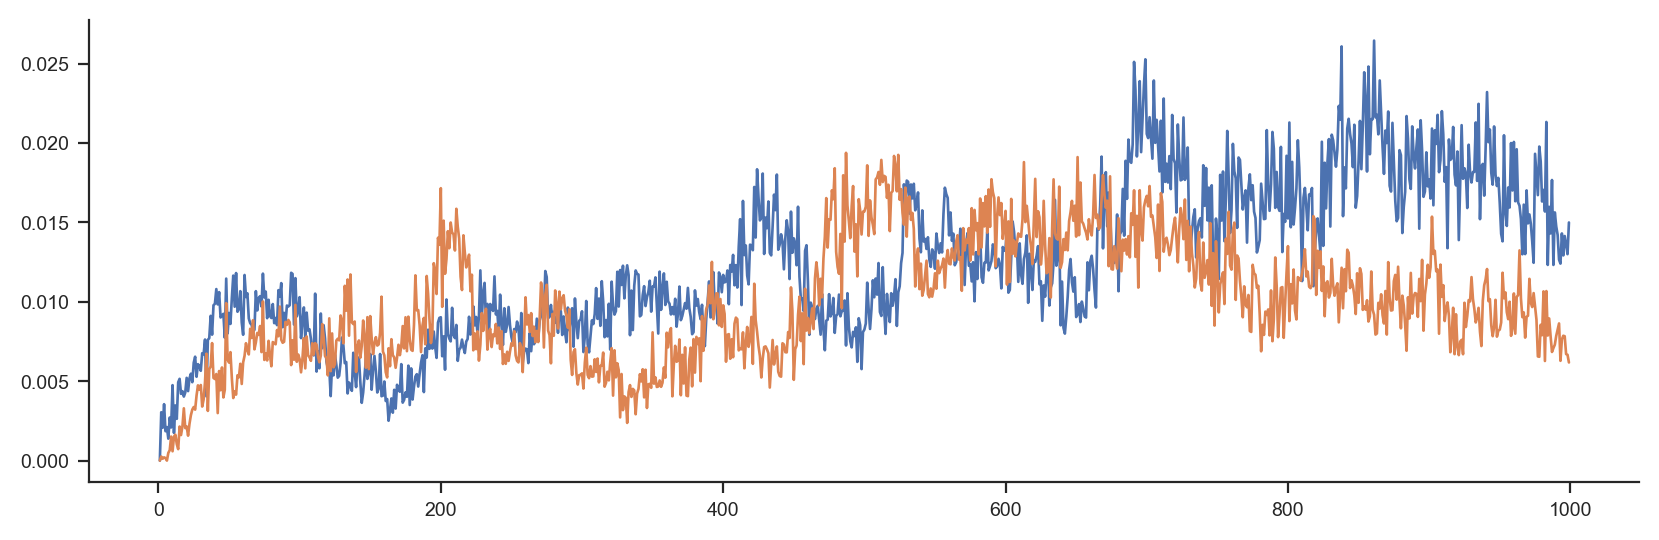

In [66]:
fig = plt.figure(figsize=(10, 3))
plt.plot(sex_ratio_std['pop1'])
plt.plot(sex_ratio_std['pop2'])
sns.despine()

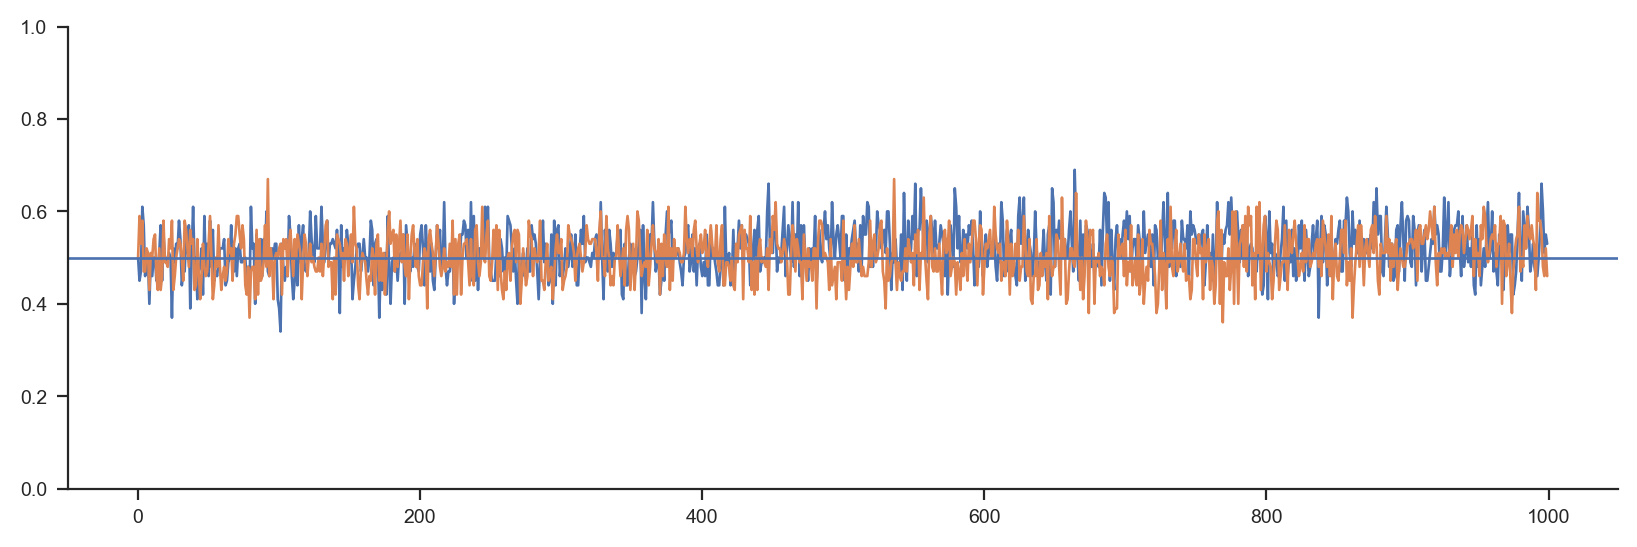

In [67]:
fig = plt.figure(figsize=(10, 3))
plt.ylim(0, 1)
plt.plot(male_ratio['pop1'])
plt.plot(male_ratio['pop2'])
plt.axhline(0.5)
sns.despine()

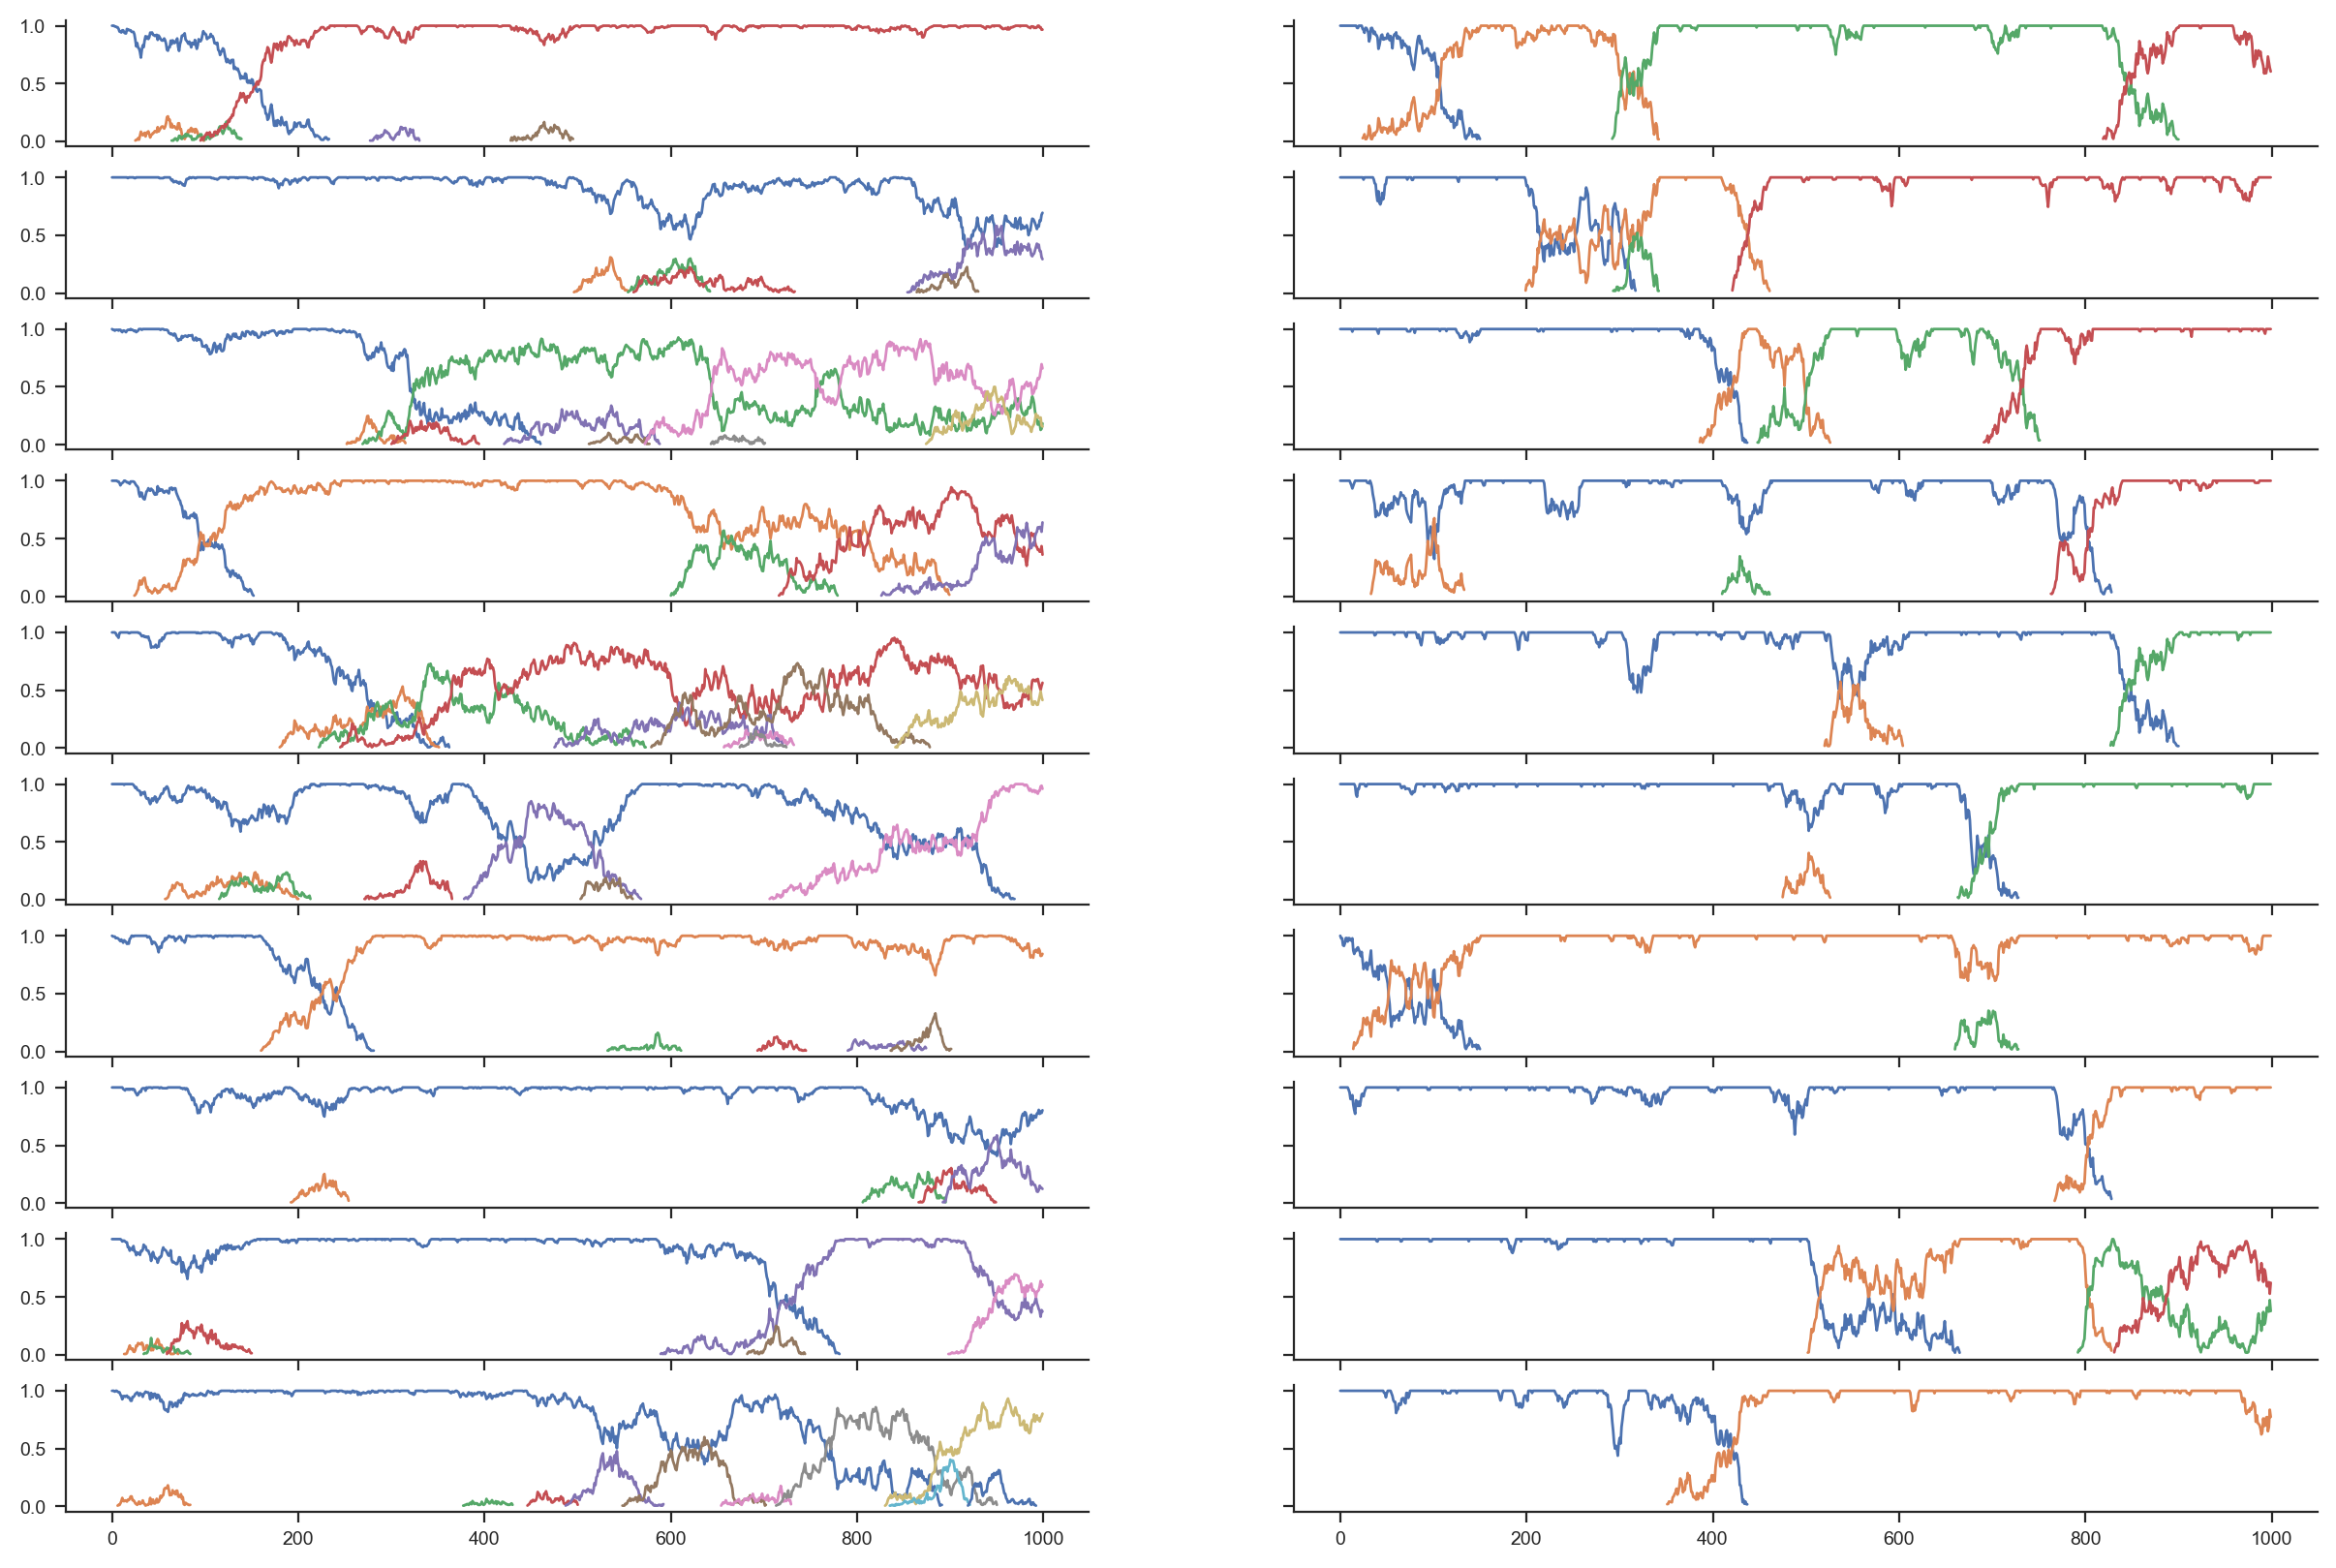

In [68]:
pop = 'pop1'
fig, axes = plt.subplots(10, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, locus in zip(axes, range(LOCI)):
    for i in x_freqs[pop][locus]:
        if len(x_freqs[pop][locus][i]) < 50: # skip plotting alleles alive for less than 50 gens
            continue

        color = None
        linewidth = None
        if allele_val_maps[locus][i] == 2:
            linewidth=3
        else:
            linewidth=1
        if not i % 2:
            ax[0].plot(x_freqs[pop][locus][i], y_freqs[pop][locus][i], linewidth=linewidth, color=color)
            for g in introgression_generations:
                ax[0].axvline(g)  
        else:
            ax[1].plot(x_freqs[pop][locus][i], y_freqs[pop][locus][i], linewidth=linewidth, color=color)
            for g in introgression_generations:
                ax[1].axvline(g)            
sns.despine() 

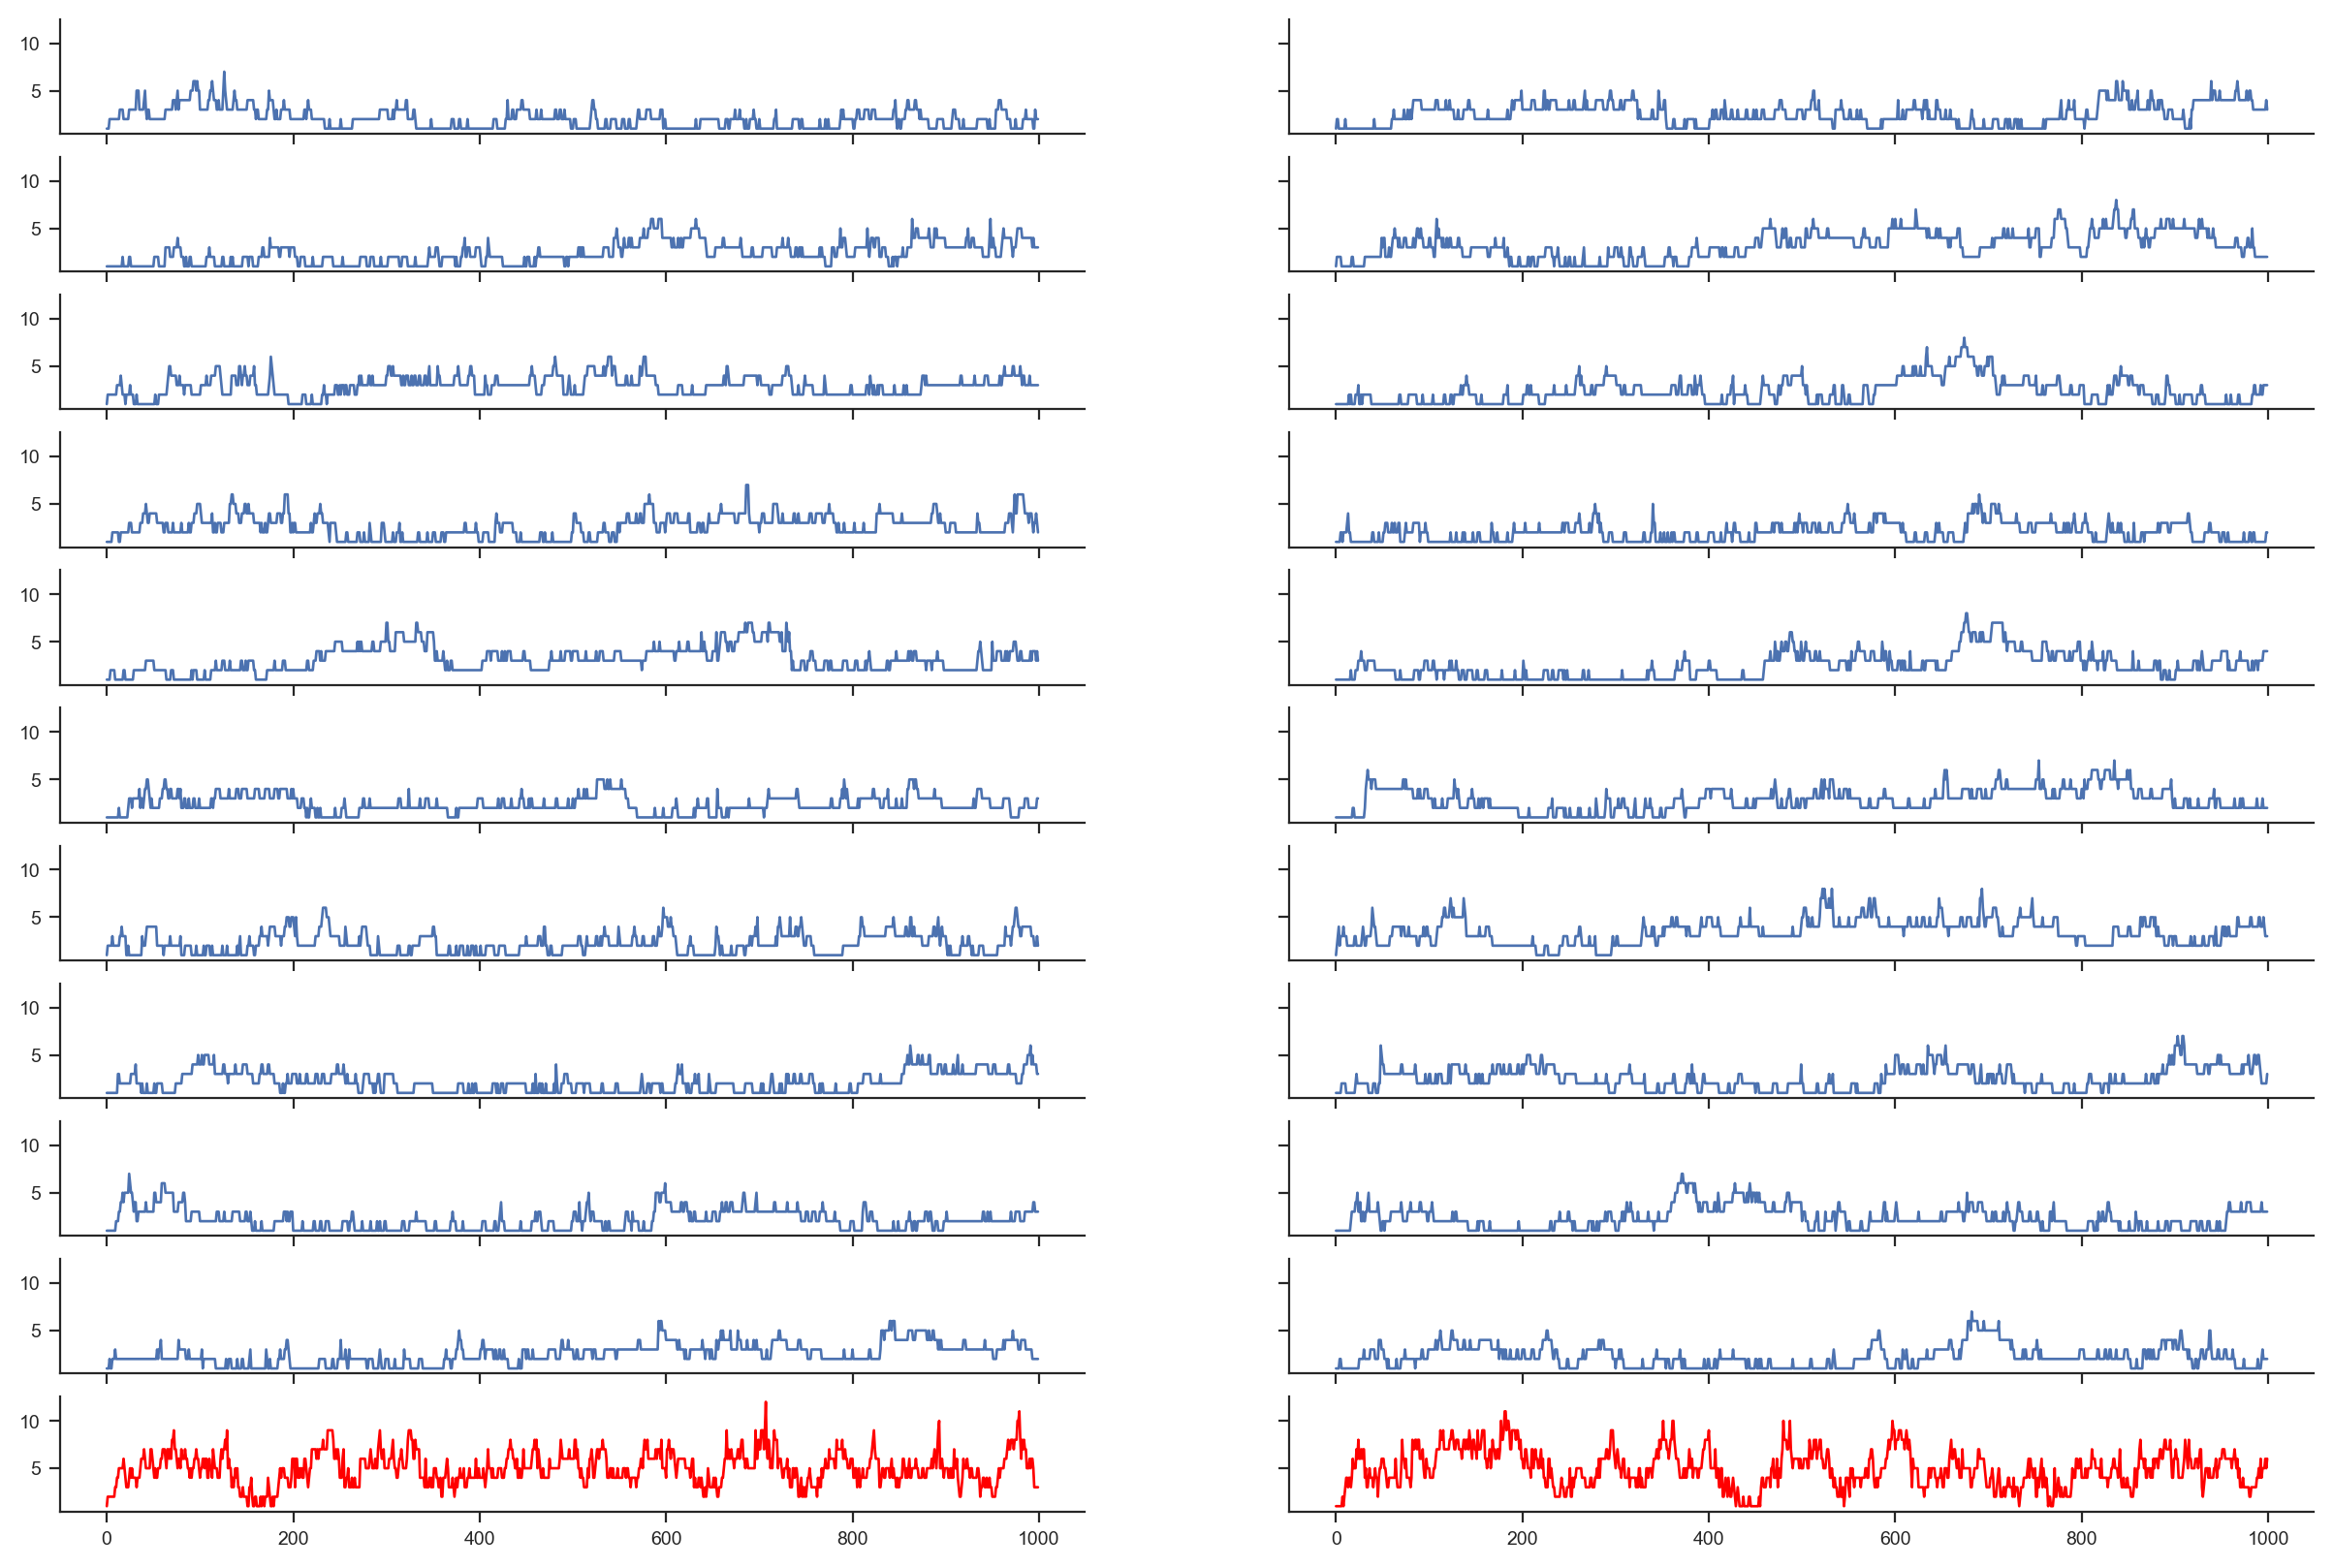

In [69]:
fig, axes = plt.subplots(11, 2, figsize=(15, 10), sharex=True, sharey=True)
for i in range(10):
    for p, pop in enumerate(['pop1', 'pop2']):
        axes[i][p].plot(nr_x_alleles[pop][i])
for p, pop in enumerate(['pop1', 'pop2']):
    axes[-1][p].plot(nr_y_alleles[pop], color='red')
sns.despine()

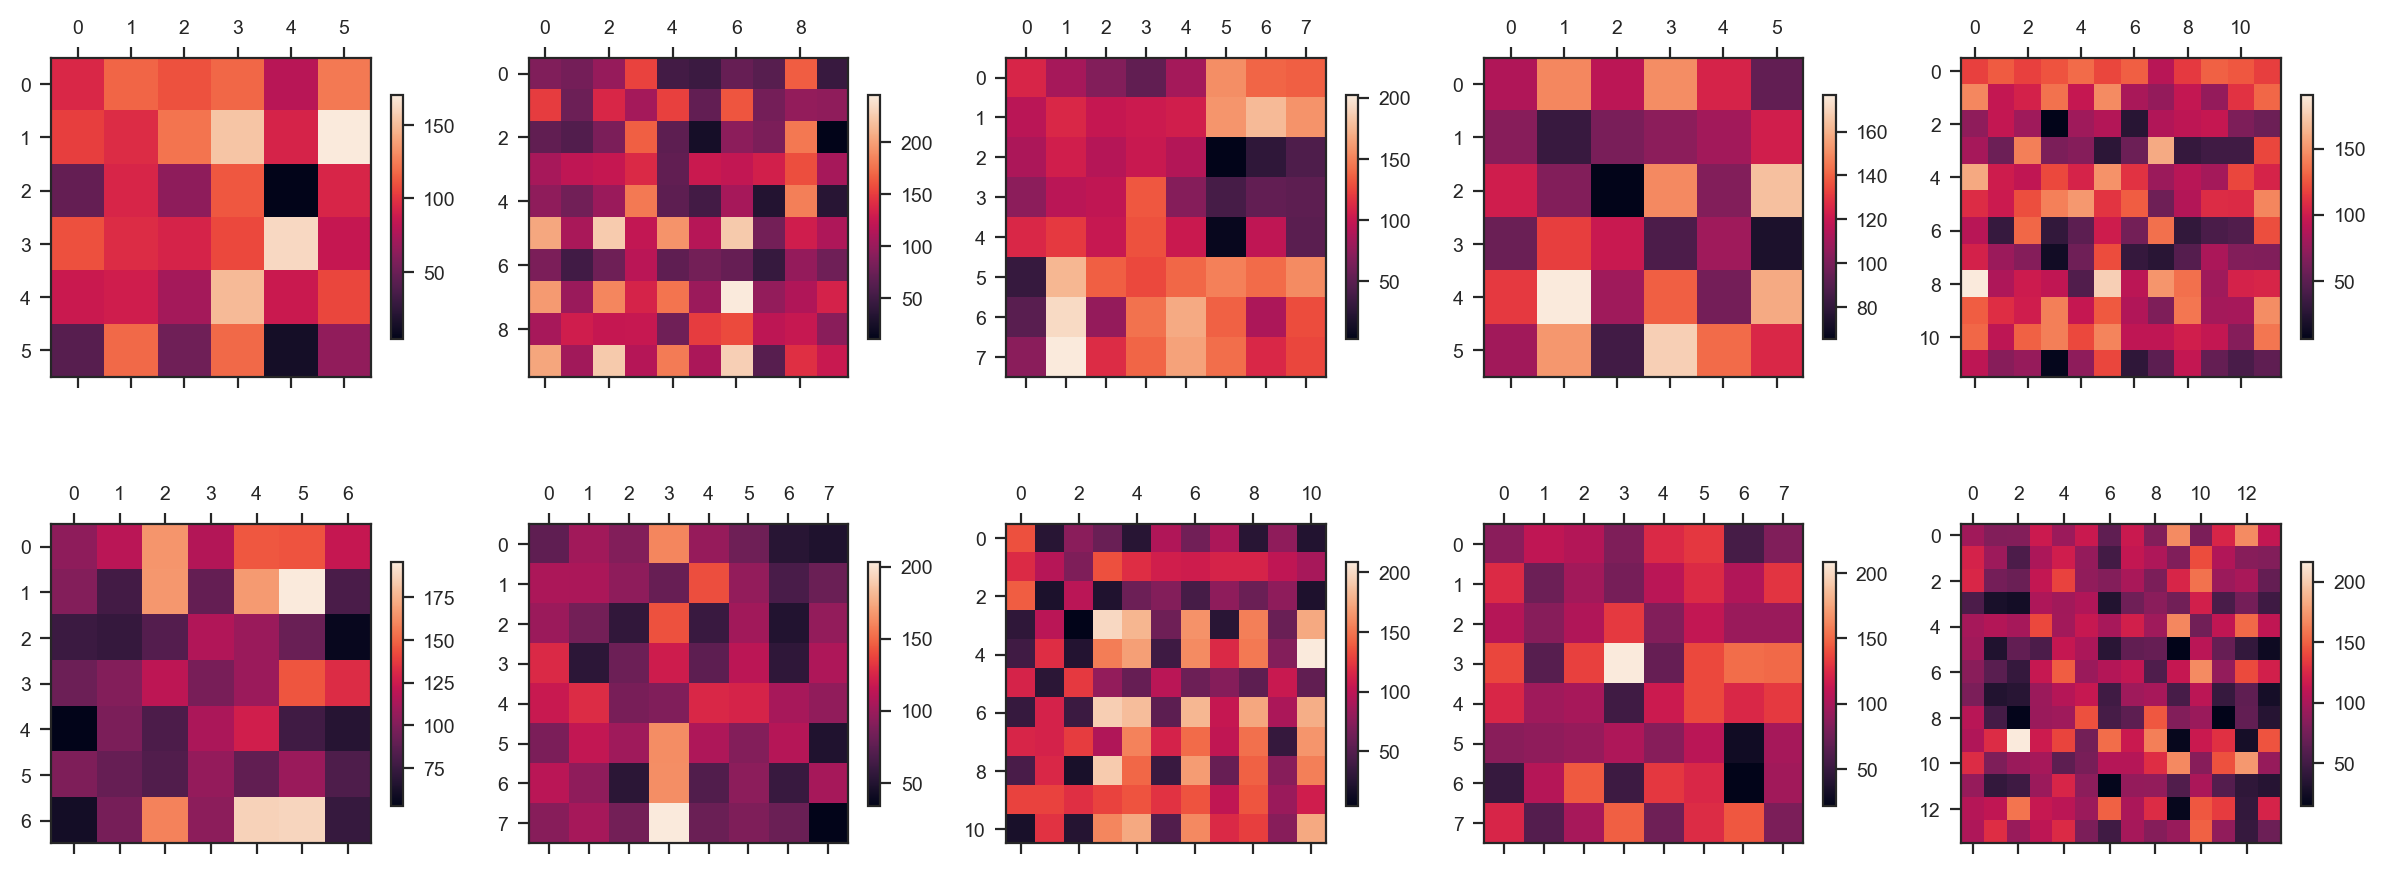

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    c = ax.matshow(np.array(DRIVES[i])) ;
    fig.colorbar(c, ax=ax, shrink=0.5)
plt.tight_layout()

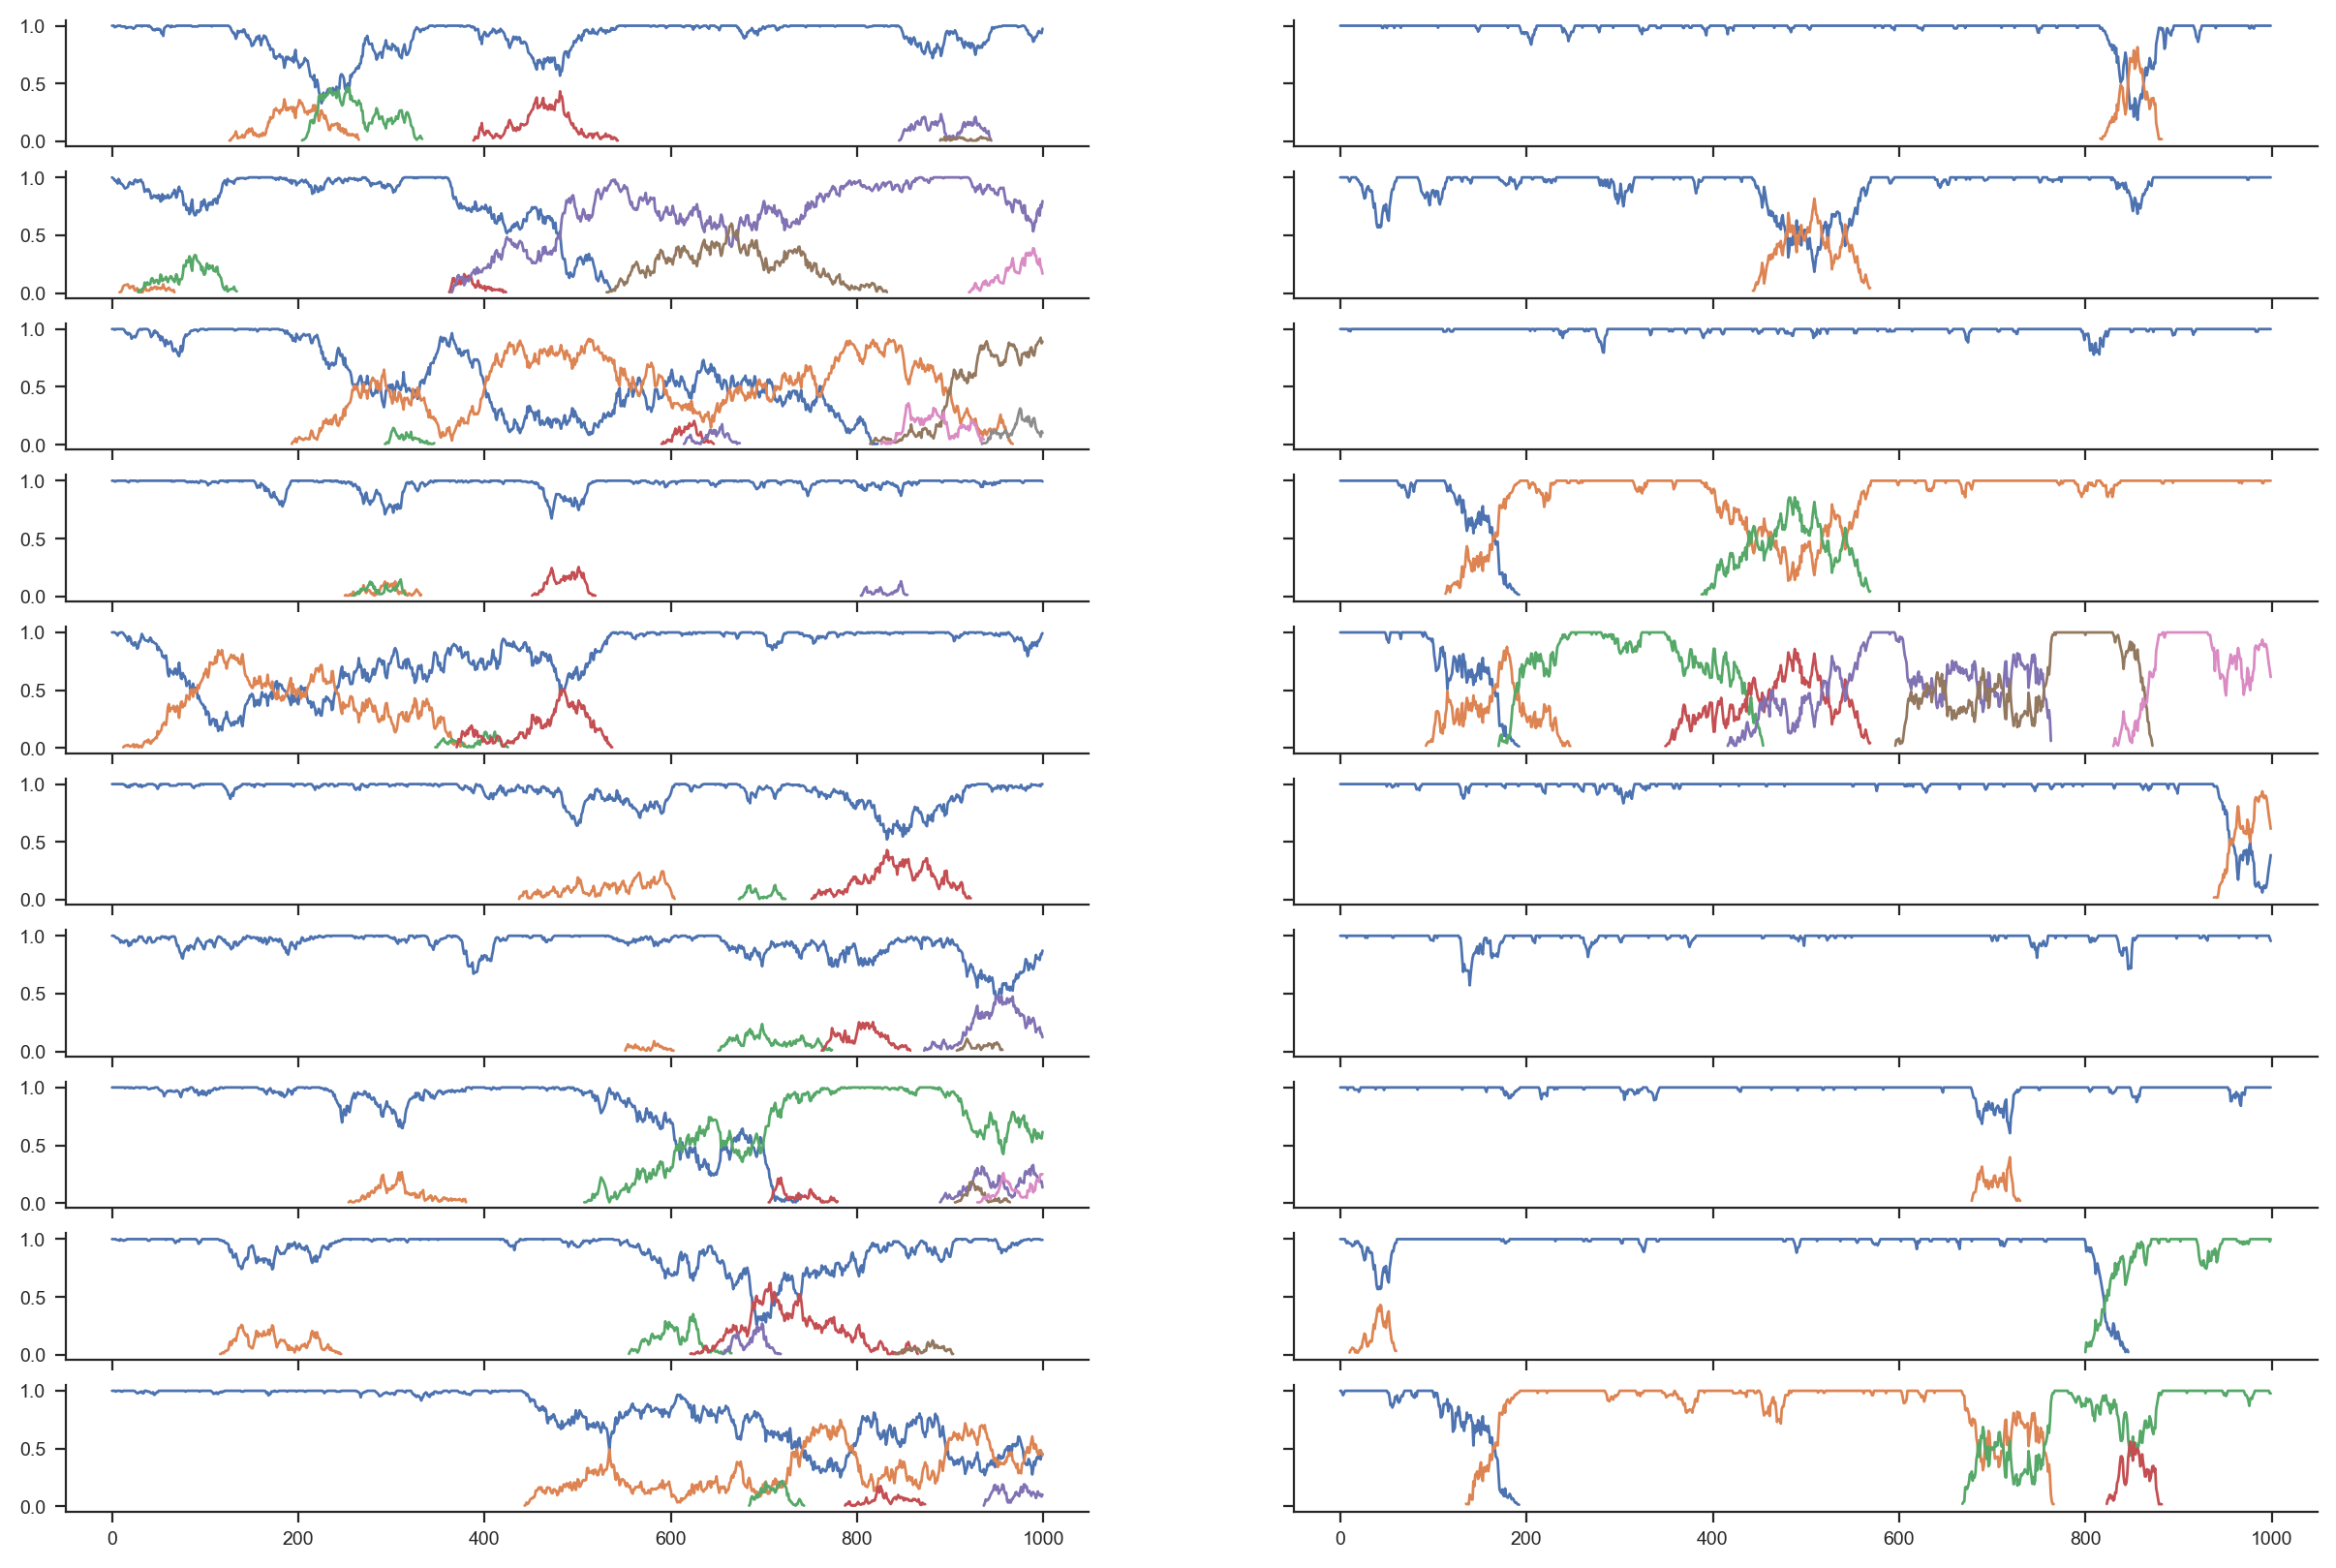

In [21]:
pop = 'pop1'
fig, axes = plt.subplots(10, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, locus in zip(axes, range(LOCI)):
    for i in x_freqs[pop][locus]:
        if len(x_freqs[pop][locus][i]) < 50: # skip plotting alleles alive for less than 50 gens
            continue

        color = None
        linewidth = None
        if allele_val_maps[locus][i] == 2:
            linewidth=3
        else:
            linewidth=1
        if not i % 2:
            ax[0].plot(x_freqs[pop][locus][i], y_freqs[pop][locus][i], linewidth=linewidth, color=color)
            for g in introgression_generations:
                ax[0].axvline(g)  
        else:
            ax[1].plot(x_freqs[pop][locus][i], y_freqs[pop][locus][i], linewidth=linewidth, color=color)
            for g in introgression_generations:
                ax[1].axvline(g)            
sns.despine()  

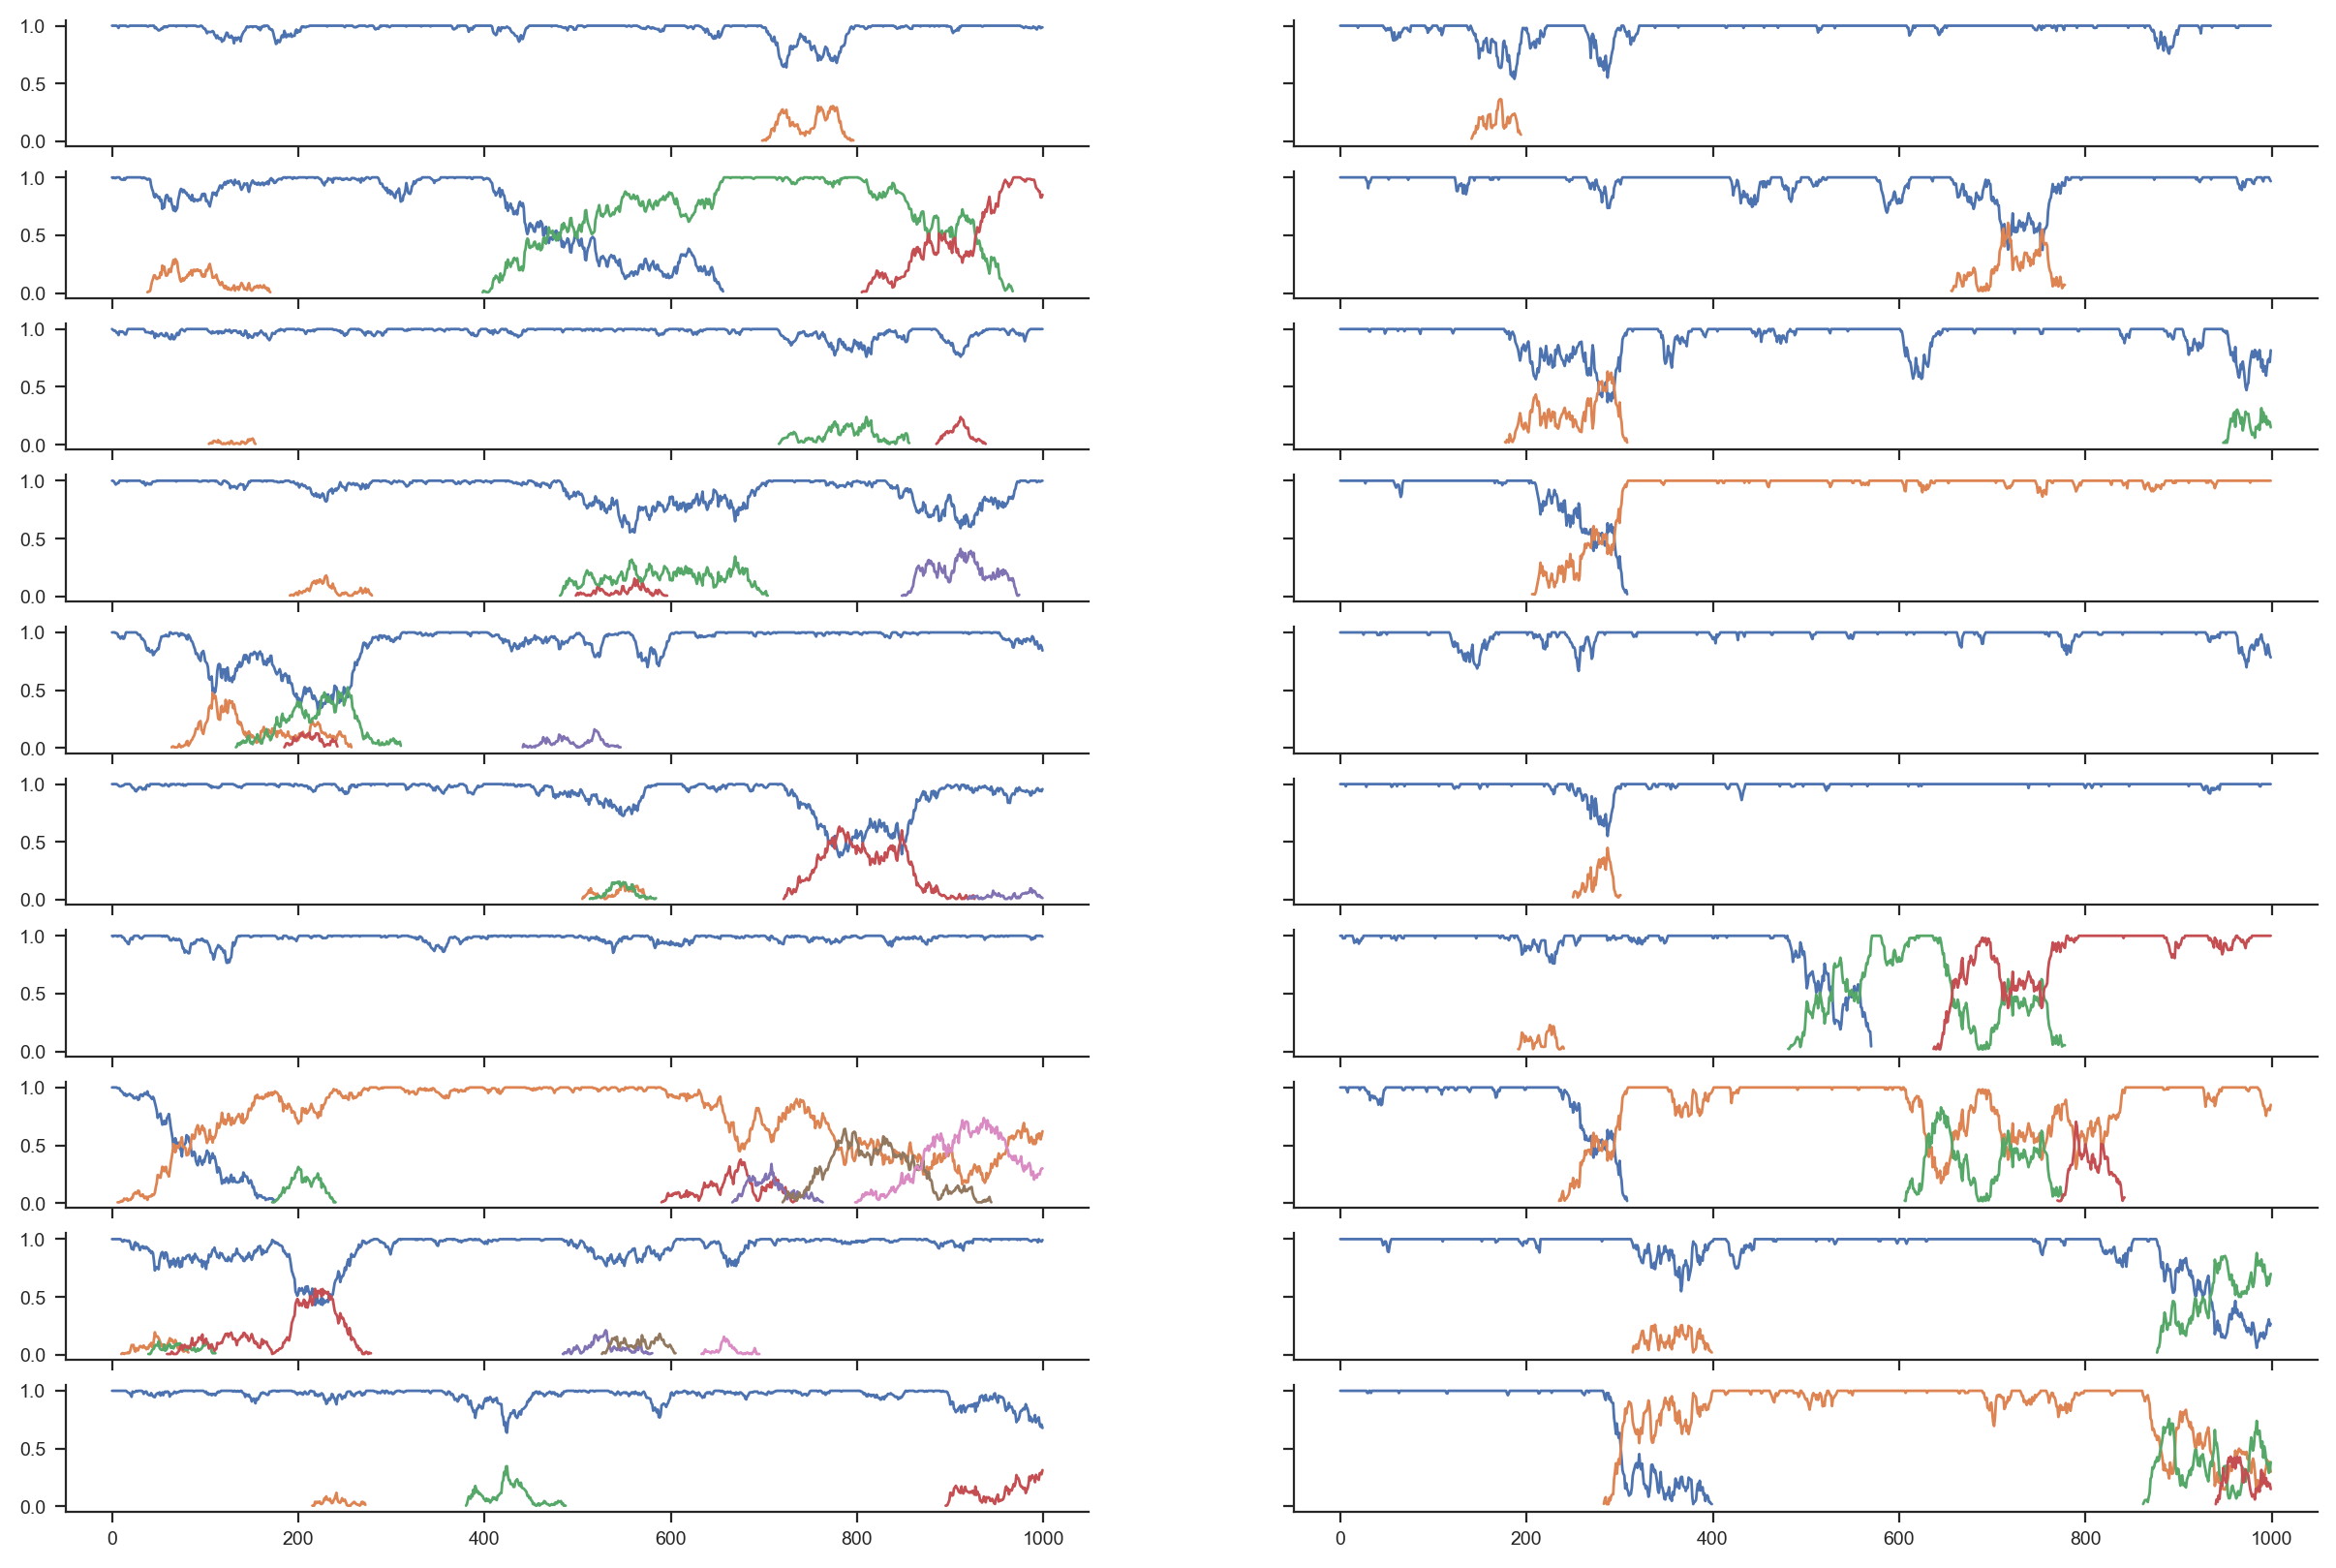

In [22]:
%matplotlib inline
pop = 'pop2'
fig, axes = plt.subplots(10, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, locus in zip(axes, range(LOCI)):
    for i in x_freqs[pop][locus]:
        if len(x_freqs[pop][locus][i]) < 50: # skip plotting alleles alive for less than 50 gens
            continue
            
        if allele_val_maps[locus][i] == 1:
            linewidth=3
        else:
            linewidth=1            
        if not i % 2:
            ax[0].plot(x_freqs[pop][locus][i], y_freqs[pop][locus][i], linewidth=linewidth, color=color)
            for g in introgression_generations:
                ax[0].axvline(g)  
        else:
            ax[1].plot(x_freqs[pop][locus][i], y_freqs[pop][locus][i], linewidth=linewidth, color=color)
            for g in introgression_generations:
                ax[1].axvline(g) 
            
sns.despine()

In [21]:
# %matplotlib ipympl
# fig, axes = plt.subplots(10, 2, figsize=(15, 10), sharex=True)
# for ax, locus in zip(axes, range(LOCI)):
#     for i in range(0, 50000, 2):
#         if x_data[locus][i]:
#             ax[0].plot(x_data[locus][i], y_data[locus][i])
#     for i in range(1, 50000, 2):
#         if x_data[locus][i]:
#             ax[1].plot(x_data[locus][i], y_data[locus][i])
# sns.despine()            

In [19]:
# ## seed(7)

# class Allele:
#     # __slots__ = ('chrom', 'label', 'val')
    
#     def __init__(self, chrom, label, val):
#         self.chrom = chrom
#         self.label = label
#         self.val = val
    
# class Male:
#     # __slots__ = ('x_alleles', 'y_alleles')
        
#     def __init__(self, x_alleles, y_alleles):
#         # assert x_allele.chrom == 'X'
#         # assert y_allele.chrom == 'Y'
#         self.x_alleles = x_alleles
#         self.y_alleles = y_alleles

#     def __add__(self, female):
      
#         # male gametes
#         x_proportion = 0
#         for locus in range(LOCI):
#             x_drive = DRIVES[locus][self.x_alleles[locus].label][self.y_alleles[locus].label]
#             y_drive = DRIVES[locus][self.y_alleles[locus].label][self.x_alleles[locus].label]
#             x_proportion += x_drive / (x_drive + y_drive)
#         x_proportion /= LOCI
                            
#         if random() < x_proportion:
#             sperm_alleles = self.x_alleles[:]
#         else:
#             sperm_alleles = self.y_alleles[:]
        
#         # female gametes
#         lst = []
#         for a, b in zip(female.x1_alleles, female.x2_alleles):
#             if random() < 0.5:
#                 lst.append([a, b])
#             else:
#                 lst.append([b, a])
#         x1_alleles, x2_alleles = map(list, zip(*lst))
            
#         if random() < 0.5:
#             egg_alleles = x1_alleles
#         else:        
#             egg_alleles = x2_alleles
  
#         # make new individual
#         if sperm_alleles[0].chrom == 'Y':
#             return Male(egg_alleles, sperm_alleles)
#         else:
#             return Female(egg_alleles, sperm_alleles)
            
# class Female:
#     # __slots__ = ('x1_alleles', 'x2_alleles')

#     def __init__(self, x1_alleles, x2_alleles):
#         # assert x1_allele.chrom == 'X'
#         # assert x2_allele.chrom == 'X'
#         self.x1_alleles = x1_alleles
#         self.x2_alleles = x2_alleles

#     def __add__(self, male):
#         return male + self

# LOCI = 10

# DRIVES = [pd.DataFrame() for _ in range(LOCI)]

# class Population:
#     # __slots__ = ('males', 'females', 'cur_xlabel', 'cur_ylabel', 'alpha', 'beta', 'pop_size', 'drive_coef')
            
#     def __init__(self, males=[], females=[], cur_xlabel=[0 for _ in range(LOCI)], cur_ylabel=[1 for _ in range(LOCI)], alpha=5, beta=1):
#         self.males = males
#         self.females = females
#         self.alpha = alpha
#         self.beta = beta
#         self.pop_size = len(self.males) + len(self.females)
#         self.drive_coef = defaultdict(dict)
#         self.cur_xlabel = cur_xlabel # label of latest x allele
#         self.cur_ylabel = cur_ylabel # label of latest y allele
        
#     def initialize(self, pop_size):
#         assert not pop_size % 2, 'initial pop_size must be even'
#         self.males = [Male([Allele('X', self.cur_xlabel[locus], 1) for locus in range(LOCI)], 
#                            [Allele('Y', self.cur_ylabel[locus], 1) for locus in range(LOCI)]) for _ in range(pop_size//2)]
#         self.females = [Female([Allele('X', self.cur_xlabel[locus], 1) for locus in range(LOCI)], 
#                                [Allele('X', self.cur_xlabel[locus], 1) for locus in range(LOCI)]) for _ in range(pop_size//2)]

#         for locus in range(LOCI):
#             self.update_drives(locus, self.cur_xlabel[locus])
#             self.update_drives(locus, self.cur_ylabel[locus])

# #     def update_drives(self, label):
# #         # assert label >= len(self.DRIVES)

# #         nrow = len(self.DRIVES[0]) if self.DRIVES else 1
# #         row = np.random.normal(self.alpha, self.beta, size=nrow).tolist()
# #         self.DRIVES.append(row)
        
# #         ncol = len(self.DRIVES)
# #         col = np.random.normal(self.alpha, self.beta, size=ncol).tolist()
# #         for row, val in zip(self.DRIVES, col):
# #             row.append(val)
            
#     def update_drives(self, locus, label):  
#         global DRIVES
        
#         assert label not in DRIVES[locus].columns.values, (label, DRIVES[locus].columns.values)
#         nrows, ncols = DRIVES[locus].shape
#         DRIVES[locus][label] = np.random.normal(self.alpha, self.beta, size=nrows)
#         nrows, ncols = DRIVES[locus].shape
#         new_row = pd.DataFrame.from_records([np.random.normal(self.alpha, self.beta, size=ncols)], 
#                                             columns=DRIVES[locus].columns)
#         new_row.index = [label]
#         DRIVES[locus] = pd.concat([DRIVES[locus], new_row])
#         DRIVES[locus] = DRIVES[locus].copy() 
        
#     def resample(self, new_pop_size=None):
#         if new_pop_size is None:
#             new_pop_size = self.pop_size
#         new_males = list()
#         new_females = list()
        
#         for i in range(new_pop_size):
#             male = self.males[int(random() * len(self.males))]
#             female = self.females[int(random() * len(self.females))]
#             child = male + female
                        
#             if isinstance(child, Male):
#                 new_males.append(child)
#             else:
#                 new_females.append(child)       
                
#         return Population(new_males, new_females, self.cur_xlabel, self.cur_ylabel)

#     def mutate(self, x_mut_prob, y_mut_prob):

#         for i in range(len(self.males)):
#             for locus in range(LOCI):
#                 if random() < x_mut_prob:
#                     self.cur_xlabel[locus] += 2
#                     self.males[i].x_alleles[locus] = Allele('X', self.cur_xlabel[locus], 1)
#                     self.update_drives(locus, self.cur_xlabel[locus])

#                 if random() < y_mut_prob:
#                     self.cur_ylabel[locus] += 2
#                     self.males[i].y_alleles[locus] = Allele('Y', self.cur_ylabel[locus], 1)
#                     self.update_drives(locus, self.cur_ylabel[locus])

#         for i in range(len(population.females)):
#             for locus in range(LOCI):
#                 if random() < x_mut_prob:
#                     self.cur_xlabel[locus] += 2
#                     self.females[i].x1_alleles[locus] = Allele('X', self.cur_xlabel[locus], 1)
#                     self.update_drives(locus, self.cur_xlabel[locus])

#                 if random() < x_mut_prob:
#                     self.cur_xlabel[locus] += 2
#                     self.females[i].x2_alleles[locus] = Allele('X', self.cur_xlabel[locus], 1)
#                     self.update_drives(locus, self.cur_xlabel[locus])
                        
#     def x_freqs(self, locus):
#         alleles = [male.x_alleles[locus].label for male in self.males] + \
#             [female.x1_alleles[locus].label for female in self.females] + \
#             [female.x2_alleles[locus].label for female in self.females]
#         unique_elements, counts_elements = np.unique(np.array(alleles), return_counts=True)
#         return unique_elements, counts_elements / counts_elements.sum()

#     def y_freqs(self, locus):
#         alleles = [male.y_alleles[locus].label for male in self.males]
#         unique_elements, counts_elements = np.unique(np.array(alleles), return_counts=True)
#         return unique_elements, counts_elements / counts_elements.sum()

#     def male_freq(self):
#         return len(self.males) / (len(self.males) + len(self.females))  
    

# # pop_size_history = [10000] * 10000
# # x_mutation_rate = 0.0001
# # y_mutation_rate = 0.0001
# # generations = 5000

# pop_size_history = [100] * 10000
# x_mutation_rate = 0.01
# y_mutation_rate = 0.01
# generations = 500

# # alpha = 1
# # beta = 5
# alpha = 5
# beta = 1

# _x = np.random.normal(alpha, beta, size=100000)
# _y = np.random.normal(alpha, beta, size=100000)
# null_dist = _x / (_x + _y)

# population = Population(alpha=alpha, beta=beta)
# population.initialize(pop_size_history.pop(0))

# x_data = {}
# y_data = {}
# for locus in range(LOCI):
#     x_data[locus] = collections.OrderedDict()
#     y_data[locus] = collections.OrderedDict()
#     nr_lines = 50000
#     for i in range(nr_lines):
#         x_data[locus][i] = []
#         y_data[locus][i] = [] 
#     x_data[locus]['nr_x_alleles'] = []
#     y_data[locus]['nr_x_alleles'] = []
#     x_data[locus]['nr_y_alleles'] = []
#     y_data[locus]['nr_y_alleles'] = []
#     x_data[locus]['male_freq'] = []
#     y_data[locus]['male_freq'] = []
#     x_data[locus]['pop_size'] = []
#     y_data[locus]['pop_size'] = []
    
# population_cache = {}
    
# for gen in trange(1, generations+1):
    
#     pop_size = pop_size_history.pop(0)
#     population = population.resample(pop_size)
#     population.mutate(x_mut_prob=x_mutation_rate, y_mut_prob=y_mutation_rate)
#     if not gen % 10:
#         population_cache[gen] = population
    
#     for locus in range(LOCI):
#         x_alleles, x_freqs = population.x_freqs(locus)
#         y_alleles, y_freqs = population.y_freqs(locus)

#         if not gen % 100:
#             live_labels = np.concatenate([x_alleles, y_alleles])
#             DRIVES[locus] = DRIVES[locus].loc[live_labels, live_labels]     

#         # plotting data
#         for x_allele, x_freq in zip(x_alleles, x_freqs):
#             x_data[locus][x_allele].append(gen)
#             y_data[locus][x_allele].append(x_freq)
#         for y_allele, y_freq in zip(y_alleles, y_freqs):
#             x_data[locus][y_allele].append(gen)
#             y_data[locus][y_allele].append(y_freq)
#         # y_data[locus]['male_freq'].append(population.male_freq())
#         # x_data[locus]['male_freq'].append(gen)
#         # y_data[locus]['nr_x_alleles'].append(len(x_alleles))
#         # x_data[locus]['nr_x_alleles'].append(gen)
#         # y_data[locus]['nr_y_alleles'].append(len(y_alleles))
#         # x_data[locus]['nr_y_alleles'].append(gen)
#         # y_data[locus]['pop_size'].append(pop_size)
#         # x_data[locus]['pop_size'].append(gen)  


# import pickle

# pickle.dump(population_cache, open( "population_cache.p", "wb" ))        
        
# %matplotlib inline
# plt.matshow(np.array(DRIVES[0])) ;

In [ ]:
# fig, axes = plt.subplots(10, 2, figsize=(15, 10))
# for ax, locus in zip(axes, range(LOCI)):
#     for i in range(0, 50000, 2):
#         if not x_data[locus][i]:
#             break
#         if len(x_data[locus][i]) > 5:
#             ax[0].plot(x_data[locus][i], y_data[locus][i])
#     for i in range(1, 50000, 2):
#         if not x_data[locus][i]:
#             break    
#         if len(x_data[locus][i]) > 5:        
#             ax[1].plot(x_data[locus][i], y_data[locus][i])
 

# if there is a lot of low freq alleles, is it then the high pi/higg ils regions that tend to sweep?

safas

In [23]:
import plotly.graph_objects as go

frames = []
for g in range(0, 1000, 10):
    scatters = []
    for i in range(1000):
        scatters.append(go.Scatter(x=x_data[i][:g], y=y_data[i][:g]))
    frames.append(go.Frame(data=scatters))
        
fig = go.Figure(
    data=[go.Scatter(x=[0], y=[0]) for _ in range(1000)],
    layout=go.Layout(
        xaxis=dict(range=[0, 1000], autorange=False),
        yaxis=dict(range=[0, 1], autorange=False),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 50, 
                                                 "redraw": False},
                                                 "fromcurrent": True, 
                                                 "transition": {"duration": 10}}])])]

                                            
    ),
    frames=frames
)

fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
import plotly.graph_objects as go

xvals = np.linspace(1, 10, 100)
yvals = np.sin(xvals)

frames = []
for i in range(len(xvals)):
    frames.append(go.Frame(data=[go.Scatter(x=xvals[:i], y=yvals[:i]),
                                 go.Scatter(x=xvals[:i], y=[p-0.2 for p in yvals[:i]])]))

fig = go.Figure(
    data=[go.Scatter(x=[0, 1], y=[0, 1]), go.Scatter(x=[0, 1], y=[0, 1])],
    layout=go.Layout(
        xaxis=dict(range=[0, 10], autorange=False),
        yaxis=dict(range=[-1, 1], autorange=False),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 50, 
                                                 "redraw": False},
                                                 "fromcurrent": True, 
                                                 "transition": {"duration": 0}}])])]

                                            
    ),
    frames=frames
)

fig.show()

In [ ]:
import plotly.express as px

df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000])
fig.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

fig=go.Figure().set_subplots(2,1, vertical_spacing=0.05,
                             specs=[[{"type": "polar"}], [{"type":"bar"}]])

r=[3.5, 1.5, 2.5, 4.5, 4.5, 4, 3]
theta=[65, 15, 210, 110, 312.5, 180, 270]
width=[20,15,10,20,15,30,15]
x= np.arange(1, 8)
bh = [4, 6, 3, 7, 8, 5, 9]


fig.add_trace(go.Barpolar(r=r[:1], theta=theta[:1], width=width[:1], 
                          marker_color="#ff8c00",
                          marker_line_color="black",
                          marker_line_width=1),1, 1)
fig.add_trace(go.Bar(x=x[:1], y=bh[:1], marker_color="green", width=0.95), 2,1);

fig.update_layout(width=800, height=700, xaxis_range=[0.5, 7.5], yaxis_range=[0, max(bh)+0.5]);

frames=[go.Frame(data=[go.Barpolar(r=r[:k+1], theta=theta[:k+1], width=width[:k+1]),
                       go.Bar(x=x[:k+1], y=bh[:k+1])],
                 name=f"fr{k}",
                 traces=[0,1]) for k in range(len(r))]  #r, theta, width, x, bh must have the same len=number of frames

fig.update(frames=frames)


def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

fr_duration=200  # customize this frame duration according to your data!!!!!
sliders = [
            {
                "pad": {"b": 10, "t": 50},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(fr_duration)],
                        "label": f"fr{k+1}",
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]


fig.update_layout(sliders=sliders,
                  updatemenus = [
                        {
                        "buttons": [
                            {
                             "args": [None, frame_args(fr_duration)],
                             "label": "&#9654;", # play symbol
                             "method": "animate",
                            },
                            {
                             "args": [[None], frame_args(fr_duration)],
                             "label": "&#9724;", # pause symbol
                             "method": "animate",
                            }],
                        "direction": "left",
                        "pad": {"r": 10, "t": 70},
                        "type": "buttons",
                        "x": 0.1,
                        "y": 0,
                        }])


